# LED Data: Nov 11,2022
## Import the libraries

In [1]:
import sys,os
import time 
import h5py

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy.optimize import curve_fit
from scipy.stats import norm

import PyMKID_USRP_functions as PUf
import PyMKID_resolution_functions as Prf
import MB_equations as MBe
import MB_analysis as MBa
import TimestreamHelperFunctions as Thf

In [2]:
# %matplotlib notebook

## Gather the files

In [3]:
datapath = '/data/USRP_Laser_Data'
series   = "20221111_110843"

sum_file, dly_file, vna_file, nse_files, led_files = Thf.GetFiles(series, 
                                                        base_path=datapath,
                                                        sep_noise_laser=True,
                                                        verbose=False)

## Load the summary file

In [4]:
md, charFs, charZs = Thf.UnpackSummary(sum_file, verbose=False)
rf_power = md['power']
# print(charFs)
# print(charZs)
print("RF Power at USRP:", rf_power, "dBm")

RF Power at USRP: -35 dBm


/home/nexus-admin/NEXUS_RF/AnalysisScripts/TimestreamHelperFunctions.py:107: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


### LED voltages
Determine how many LED timestream files there are and get an array of the LED voltages used for each.

In [5]:
voltages = np.array([])

for k in md.keys():
    if 'LaserScan_' in k:
        voltages = np.append(voltages, float(int(1000*md[k]['LEDvoltage'][0]))/1000.)

n_volts  = len(voltages)
n_runs   = len(led_files)
print(n_volts, n_runs, "<-- These should be the same")
print("Vmin = ",np.min(voltages), "V")
print("Vmax = ",np.max(voltages), "V")
# print("Vstep = ",int((voltages[1]-voltages[0])*1e3), "mV")

29 29 <-- These should be the same
Vmin =  2.6 V
Vmax =  3.999 V


### Define some PSD parameters

In [6]:
## PSD hi and lo frequency limits
chunk_up_to      = 1e2
decimate_down_to = 5e4

## Transient period at front of timestream
blank_fraction = 0.2

### Extract the pulse profile
This assumes that each laser timestream is acquired with the same AWG settings.

In [7]:
LED_rate_Hz = 0 # 100.0
lapse_sec   = 0 # 10.0

## Extract the pulse settings, assuming they're all the same
for k in md.keys():
    if 'LaserScan_' in k:
        LED_rate_Hz = md[k]['LEDfreqHz'][0]
        lapse_sec   = md[k]['duration'][0]
        pulse_w     = md[k]['LEDpulseus'][0]
#         delay_ms    = md[k]['delayms'][0]
        break
LED_rate_Hz = LED_rate_Hz   #*5
print("Pulse f: ",LED_rate_Hz,"Hz")
print("Pls wdth:",pulse_w,"us")
print("Duration:",lapse_sec,"sec")
# print("P  delay:",delay_ms,"ms")

total_pulses = LED_rate_Hz*lapse_sec

time_btw_pulse = 1./LED_rate_Hz
num_pulses = int(total_pulses * (1 - blank_fraction))
print("Total pulse windows:",total_pulses)
print("Time between pulse arrival:",time_btw_pulse,"sec")
print("Number of windows to look at:",num_pulses)

Pulse f:  80.0 Hz
Pls wdth: 1.0 us
Duration: 10.0 sec
Total pulse windows: 800.0
Time between pulse arrival: 0.0125 sec
Number of windows to look at: 640


## Noise cleaning to get cleaning coefficients

Will separate data into  1000 chunks to achieve the requested 1.00e+02  Hz low  end of the PSD
Additional decimation by 20 needed to achieve the requested 5.00e+04  Hz high end of the PSD
Will convert to resonator basis!
doing additional decimation
sampling frequency plugged into welch is 50000
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_Data/20221111/20221111_110843/USRP_Noise_20221111_110843_delta0.h5 because override=True!
found 2 pulses
chunk length plugged into welch is 500
chunked data into 1000 timestreams
computed electronics basis
cleaning...
(2, 399000)
(1, 399000)
(1, 399000)
(2, 399000)
(1, 399000)
(1, 399000)
saving clean_data to /data/USRP_Laser_Data/20221111/20221111_110843/USRP_Noise_20221111_110843_delta0_cleaned.h5 because override=True!
number of chunks used to average is 798
Converting to resonator basis!
Fr from fit  [GHz]: 4242.049060503813
Fr min curve [GHz]: 4242.048720750536
Fr from 

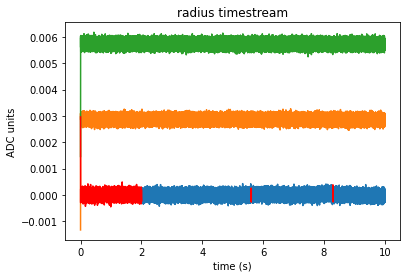

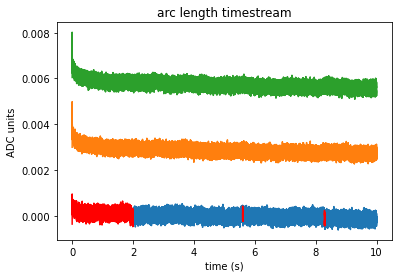

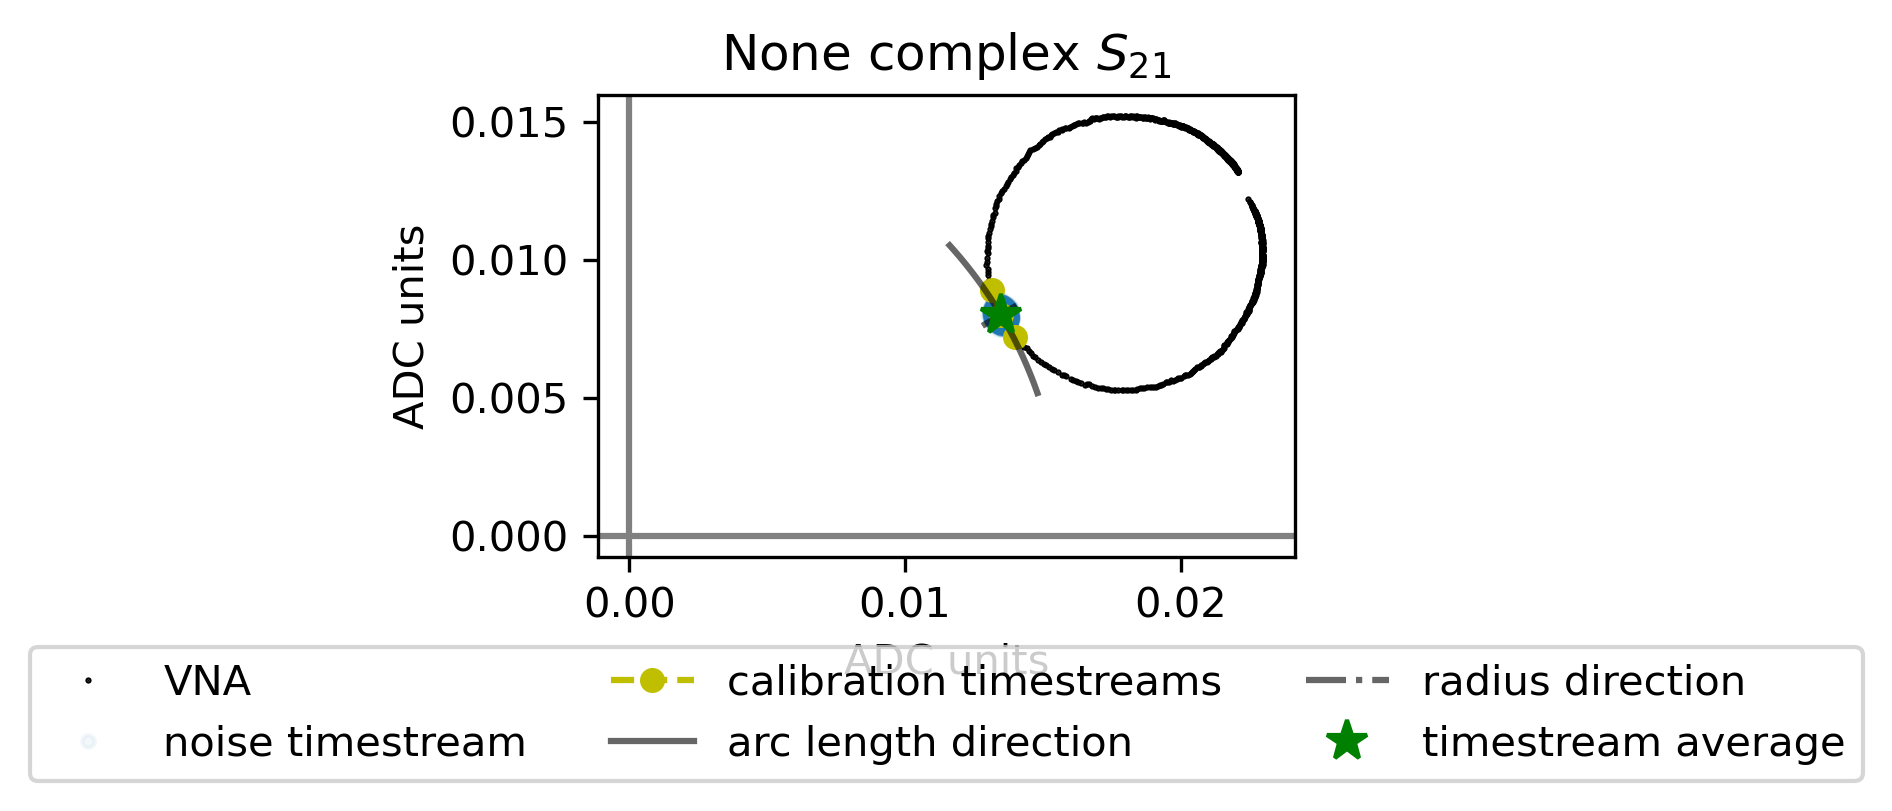

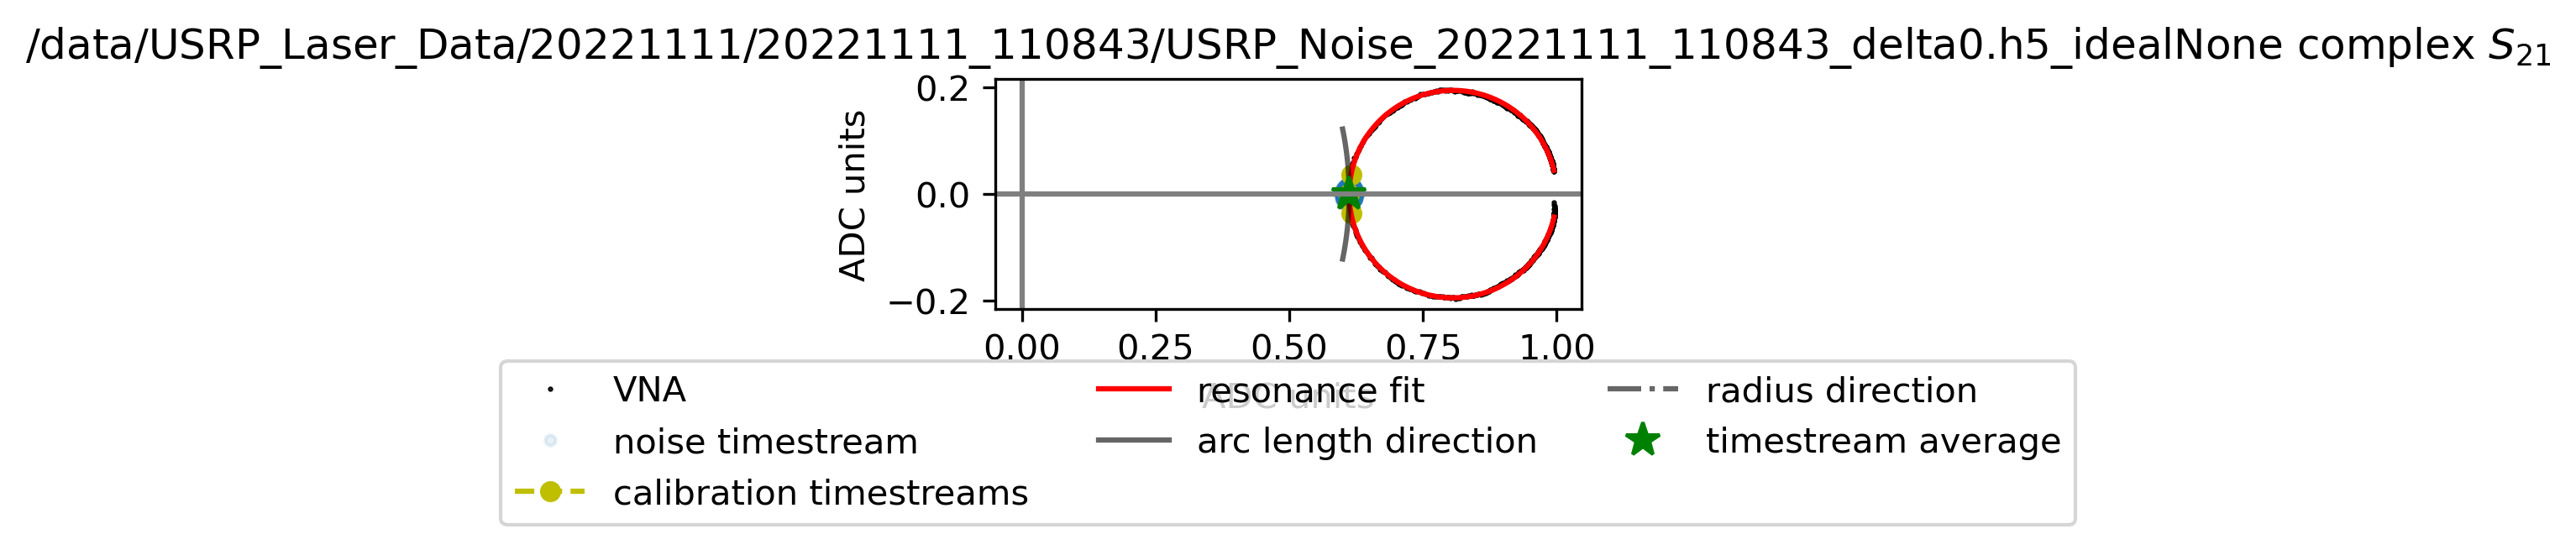

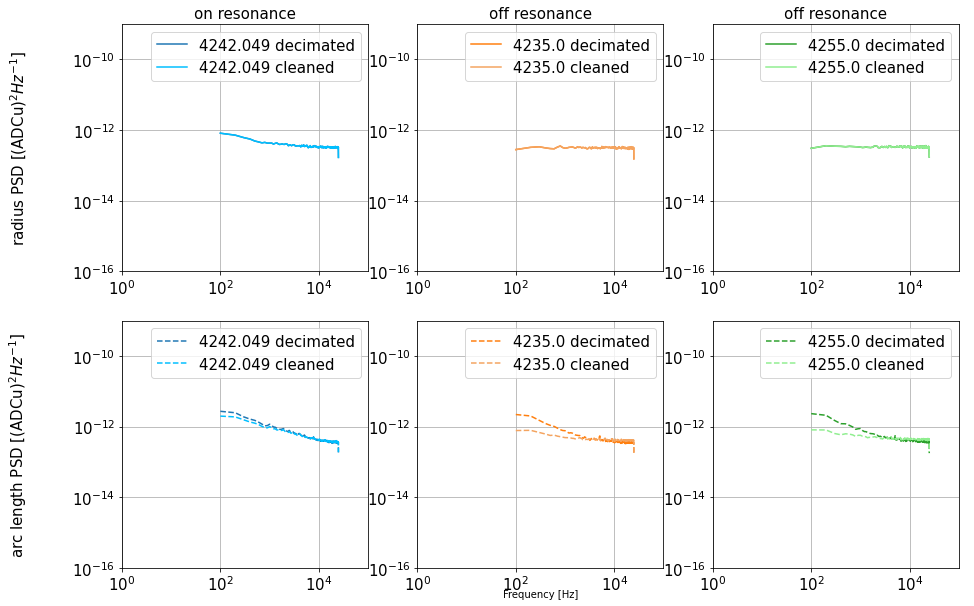

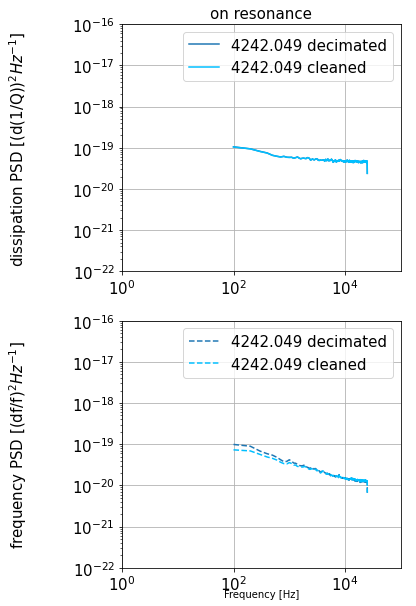

In [8]:
## Do the cleaning of the noise file
powers, PSDs, res, timestreams = Thf.CleanPSDs(
    nse_files[0], 
    vna_file, 
    PSD_lo_f=chunk_up_to, 
    PSD_hi_f=decimate_down_to, 
    f_transient=blank_fraction, 
    charFs=charFs, 
    charZs=charZs)

## Pick which files to scan

In [9]:
files_to_skip = 0 ## How many to skip at beginning
files_to_trim = 0 ## How many to cut off at end

LED_files = led_files[files_to_skip:n_runs-files_to_trim]
Voltages  = voltages[files_to_skip:n_runs-files_to_trim]

## Pulse window plotting and removal of bad windows

In [10]:
show_plots = False

## Window selection
pretrig_seconds = 4.75e-3 # -5.0e-3

## Create dictionaries to store the cut criteria parameters
mean_dict = {}
sdev_dict = {}
maxv_dict = {}

## Loop over every file (LED voltage)
for pulse_file in LED_files:
    print('===================')
    print('plotting pulse file:',pulse_file)
    print('using VNA file:     ',vna_file)
    print('using noise file:   ',nse_files[0])
    noise_file = nse_files[0]

    ## Determine how much additional decimation to apply
    pulse_noise, pulse_info = PUf.unavg_noi(pulse_file)
    pulse_fs = 1./pulse_info['sampling period']
    pulse_cleaning_decimation = int(pulse_fs/decimate_down_to)

    ## Get the decimated timestream and frequency step
    pulse_noise = Prf.average_decimate(pulse_noise,pulse_cleaning_decimation)
    pulse_fs   /= pulse_cleaning_decimation
    
    ## Create a new array of of frequency space with the applied decimation
    sampling_rate = pulse_fs
    samples_per_pulse = int(time_btw_pulse*sampling_rate)
    N = int(samples_per_pulse)-1
    T = N/sampling_rate
    t,f = Prf.build_t_and_f(N,sampling_rate)
    
    ## Define the regions where pulses exist
    ## =====================================
    
    ## This defines where (in # of pulse windows) to start looking for pulse windows
    pulse_start = int(total_pulses * blank_fraction)
    
    ## How many samples to shift the pulse window definition
    pretrig = int(pretrig_seconds * sampling_rate)
    
    ## Create an empty array to store our results in
    ## This is the average baseline of the three timestreams across all pulse windows
    noise_averages = np.zeros((3),dtype=np.complex128)
    
    ## Create empty arrays to store values which we will use to perform quality cuts
    ## These will have an entry for each pulse window
    bl_means = np.array([],dtype=np.complex128)
    bl_sdevs = np.array([],dtype=np.complex128)
    pls_maxs = np.array([],dtype=np.complex128)
    
    ## Create plots to store waveforms
    if show_plots:
        fi0 = plt.figure(pulse_file+"_a")
        ax0 = fi0.gca()
        ax0.set_xlabel("Time [ms]")
        ax0.set_ylabel(r"$\log_{10}|S_{21}|$")
        ax0.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))

        fi1 = plt.figure(pulse_file+"_b")
        ax1 = fi1.gca()
        ax1.set_xlabel(r"$\Re(S_{21})$")
        ax1.set_ylabel(r"$\Im(S_{21})$")
        ax1.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
    
    ## Start the loop over pulse windows
    k=0
    for pulse_i in range(pulse_start,int(total_pulses),1):
        
        ## Define the sample index where this pulse window ends
        pulse_i_end = int((pulse_i+1)*samples_per_pulse)
        
        ## Define the edges of the pulse window
        pulse_idx_start = pulse_i_end - N
        pulse_idx_end   = pulse_i_end
        
        ## Grab the timestream in that region and average it
        full_pulse_chunk  = pulse_noise[pulse_idx_start:pulse_idx_end,:]
        pretrig_pls_chunk = pulse_noise[pulse_idx_start:pulse_idx_start+pretrig,:]
        
        ## Calculate some means and stdevs of the pre-trigger region of this pulse window
        m = np.mean(pretrig_pls_chunk,axis=0,dtype=np.complex128) ; bl_means = np.append(bl_means,m[0])
        s = np.std( pretrig_pls_chunk,axis=0,dtype=np.complex128) ; bl_sdevs = np.append(bl_sdevs,s[0])
        
        ## Calculate the maximum point in the entire waveform
        x = np.max( np.log10(abs(full_pulse_chunk)) ,axis=0)      ; pls_maxs = np.append(pls_maxs,x[0])
        
        ## Keep a running average of the baseline noise in pre-trigger region across all pulse regions
        noise_averages += m    
        
        ## Plot the pulse free region against time
        if show_plots:
            ax0.plot(t*1e3,np.log10(abs(full_pulse_chunk[:,0])),alpha=0.25)
            ax1.scatter(full_pulse_chunk[:,0].real,full_pulse_chunk[:,0].imag,alpha=0.25)
        
        ## Increment the good pulse counter
        k += 1
        
    ## Average the baseline mean over every pulse window
    noise_averages /= k
    
    ## Save the cut criteria to our dictionaries
    mean_dict[pulse_file] = bl_means
    sdev_dict[pulse_file] = bl_sdevs
    maxv_dict[pulse_file] = pls_maxs
         
    ## Draw some lines to mark the pulse window regions
    if show_plots:
        ax0.axhline(y=np.log10(abs(noise_averages[0])),color="k",ls='--')
        ax0.axvline(x=pretrig_seconds*1e3,color="k",ls=':')
    
    ## Create plots that inform our cuts
    if show_plots:
        fi2 = plt.figure(pulse_file+"_c")
        ax2 = fi2.gca()
        ax2.hist(np.log10(abs(bl_means)), 
                 bins=np.arange(
                     start = np.min( np.log10(abs(bl_means)) ) ,
                     stop  = np.max( np.log10(abs(bl_means)) ) ,
                     step  = 5e-4))
        ax2.axvline(x=np.percentile(np.log10(abs(bl_means)),25), color="k",ls='--')
        ax2.axvline(x=np.percentile(np.log10(abs(bl_means)),75), color="k",ls='--')
        ax2.axvline(x=-1.808, color="r",ls=':')
        ax2.axvline(x=-1.802, color="r",ls=':')
        ax2.axvline(x=np.percentile(np.log10(abs(bl_means)),75), color="k",ls='--')
        ax2.set_xlabel(r"Pre-trigger BL mean $\log_{10}(|S_{21}|)$")
        ax2.set_ylabel("Occurences")
        ax2.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))

        fi3 = plt.figure(pulse_file+"_d")
        ax3 = fi3.gca()
        ax3.hist(np.log10(abs(bl_sdevs)), 
                 bins=np.arange(
                     start = np.min( np.log10(abs(bl_sdevs)) ) ,
                     stop  = np.max( np.log10(abs(bl_sdevs)) ) ,
                     step  = 5e-3))
        ax3.axvline(x=np.percentile(np.log10(abs(bl_sdevs)),25), color="k",ls='--')
        ax3.axvline(x=np.percentile(np.log10(abs(bl_sdevs)),75), color="k",ls='--')
        ax3.axvline(x=-3.86, color="r",ls=':')
        ax3.axvline(x=-3.81, color="r",ls=':')
        ax3.set_xlabel(r"Pre-trigger BL sdev $\log_{10}(|S_{21}|)$")
        ax3.set_ylabel("Occurences")
        ax3.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))

plotting pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.600V_20221111_110843.h5
using VNA file:      /data/USRP_Laser_Data/20221111/20221111_110843/USRP_VNA_20221111_110843.h5
using noise file:    /data/USRP_Laser_Data/20221111/20221111_110843/USRP_Noise_20221111_110843_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.650V_20221111_110843.h5
using VNA file:      /data/USRP_Laser_Data/20221111/20221111_110843/USRP_VNA_20221111_110843.h5
using noise file:    /data/USRP_Laser_Data/20221111/20221111_110843/USRP_Noise_20221111_110843_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.700V_20221111_110843.h5
using VNA file:      /data/USRP_Laser_Data/20221111/20221111_110843/USRP_VNA_20221111_110843.h5
using noise file:    /data/USRP_Laser_Data/20221111/20221111_110843/USRP_Noise_20221111_110843_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_Las

plotting pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_3.850V_20221111_110843.h5
using VNA file:      /data/USRP_Laser_Data/20221111/20221111_110843/USRP_VNA_20221111_110843.h5
using noise file:    /data/USRP_Laser_Data/20221111/20221111_110843/USRP_Noise_20221111_110843_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_3.900V_20221111_110843.h5
using VNA file:      /data/USRP_Laser_Data/20221111/20221111_110843/USRP_VNA_20221111_110843.h5
using noise file:    /data/USRP_Laser_Data/20221111/20221111_110843/USRP_Noise_20221111_110843_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_3.950V_20221111_110843.h5
using VNA file:      /data/USRP_Laser_Data/20221111/20221111_110843/USRP_VNA_20221111_110843.h5
using noise file:    /data/USRP_Laser_Data/20221111/20221111_110843/USRP_Noise_20221111_110843_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_Las

## Define the Cuts (-35 dBm run)

In [11]:
## Define a file path and name where cut limits will be stored
save_path = "/".join(LED_files[0].split("/")[:5])
save_name = series + "_bl_cutvals" 
save_key  = series+"_cuts"

force_save = False

## Check if cuts already exist
if ( os.path.exists(os.path.join(save_path,save_name+".h5")) ) and not force_save:
    cut_df = pd.read_hdf(os.path.join(save_path,save_name+".h5"), key=save_key)
    save_cuts = False
elif ( os.path.exists(os.path.join(save_path,save_name+".csv")) ) and not force_save:
    cut_df = pd.read_csv(os.path.join(save_path,save_name+".h5"))
    save_cuts = False
else:
    save_cuts = True
    
    ## Create a pandas dataframe for the cut limits
    cut_df = pd.DataFrame(index=LED_files,columns=None)

    ## Define the columns we'll use to store cut limits
    cut_df["sdev_min"] = np.ones(len(LED_files))
    cut_df["sdev_max"] = np.ones(len(LED_files))
    cut_df["mean_min"] = np.ones(len(LED_files))
    cut_df["mean_max"] = np.ones(len(LED_files))

    ## Now populate each row in the dataframe

    ## 2.60 V
    _i = -5
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.816
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.811
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.865
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.795

    ## 2.65 V
    _i = -4
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.816
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.811
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.865
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.795

    ## 2.70 V
    _i = -3
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.816
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.811
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.865
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.795

    ## 2.75 V
    _i = -2
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.816
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.811
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.865
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.795

    ## 2.80 V
    _i = -1
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.812
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.8095
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.86
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.80


    ## 2.85 V
    _i = 0
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.807
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.804
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.850
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.810

    ## 2.90 V
    _i = 1
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.806
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.8025
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.850
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.810

    ## 2.95 V
    _i = 2
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.804
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.8015
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.850
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.810

    ## 3.00 V
    _i = 3
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.808
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.805
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.850
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.810

    ## 3.05 V
    _i = 4
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.8055
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.8035
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.850
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.810

    ## 3.10 V -- Baseline shift during this run
    _i = 5
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.810
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.8075
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.850
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.810

    ## 3.15 V
    _i = 6
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.8115
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.809
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.840
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.800

    ## 3.20 V
    _i = 7
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.813
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.810
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.850
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.800

    ## 3.25 V -- Baseline shift during this run
    _i = 8
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.813
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.810
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.850
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.800

    ## 3.30 V
    _i = 9
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.805
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.800
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.850
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.800

    ## 3.35 V
    _i = 10
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.8095
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.8055
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.850
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.800

    ## 3.40 V
    _i = 11
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.800
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.795
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.850
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.800

    ## 3.45 V
    _i = 12
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.797
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.791
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.860
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.810

    ## 3.50 V
    _i = 13
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.792
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.788
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.860
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.810

    ## 3.55 V
    _i = 14
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.8035
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.8000
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.860
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.810

    ## 3.60 V
    _i = 15
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.797
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.793
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.860
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.800

    ## 3.65 V
    _i = 16
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.806
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.802
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.850
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.805

    ## 3.70 V
    _i = 17
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.800
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.796
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.860
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.810

    ## 3.75 V -- Bimodal
    _i = 18
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.8025
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.7980
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.865
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.805

    ## 3.80 V
    _i = 19
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.802
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.798
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.865
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.805

    ## 3.85 V
    _i = 20
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.803
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.799
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.865
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.805

    ## 3.90 V
    _i = 21
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.807
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.803
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.860
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.810

    ## 3.95 V
    _i = 22
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.8045
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.8000
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.850
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.810

    ## 4.00 V -- Baseline shift during this run
    _i = 23
    cut_df["mean_min"].loc[LED_files[_i+5]] = -1.8015
    cut_df["mean_max"].loc[LED_files[_i+5]] = -1.7995
    cut_df["sdev_min"].loc[LED_files[_i+5]] = -3.860
    cut_df["sdev_max"].loc[LED_files[_i+5]] = -3.790

    if (save_cuts or force_save):
        print("Saving cuts to file", os.path.join(save_path,save_name))
        cut_df.to_hdf( os.path.join(save_path,save_name+".h5") , save_key)
        cut_df.to_csv( os.path.join(save_path,save_name+".csv"))
        
cut_df

,sdev_min,sdev_max,mean_min,mean_max
/data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.600V_20221111_110843.h5,-3.865,-3.795,-1.8160,-1.8110
/data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.650V_20221111_110843.h5,-3.865,-3.795,-1.8160,-1.8110
/data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.700V_20221111_110843.h5,-3.865,-3.795,-1.8160,-1.8110
/data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.750V_20221111_110843.h5,-3.865,-3.795,-1.8160,-1.8110
/data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.800V_20221111_110843.h5,-3.860,-3.800,-1.8120,-1.8095
/data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.850V_20221111_110843.h5,-3.850,-3.810,-1.8070,-1.8040
/data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.900V_20221111_110843.h5,-3.850,-3.810,-1.8060,-1.8025
/data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.950V_20221111_110843.h5,-3.850,-3.810,-1.8040,-1.8015
/data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_3.000V_20221111_110843.h5,-3.850,-3.810,-1.8080,-1.8050
/data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_3.050V_20221111_110843.h5,-3.850,-3.810,-1.8055,-1.8035


## Apply the Cuts

In [12]:
## Create a dictionary that will contain arrays of bad pulse indeces
bad_pls_idxs = {}

## Loop over every file (LED voltage)
for pulse_file in LED_files:
    
    ## Extract the cut criteria limits
    bl_mean_min = cut_df["mean_min"].loc[pulse_file]
    bl_mean_max = cut_df["mean_max"].loc[pulse_file]
    bl_sdev_min = cut_df["sdev_min"].loc[pulse_file]
    bl_sdev_max = cut_df["sdev_max"].loc[pulse_file]
    
    ## Extract the cut criteria dictionaries
    bl_means = np.log10(abs(mean_dict[pulse_file]))
    bl_sdevs = np.log10(abs(sdev_dict[pulse_file]))
    pls_maxs = np.log10(abs(maxv_dict[pulse_file]))
    
    ## Create an empty array for the bad pulse indeces
    bad_pulses = np.array([])
    
    ## Loop over pulse windows
    for k in np.arange(len(bl_means)):
        
        ## Check the cuts for baseline mean
        if (bl_means[k] < bl_mean_min) or (bl_means[k] > bl_mean_max):
            bad_pulses = np.append(bad_pulses, k)
            continue
            
        ## Check the cuts for baseline sdev
        if (bl_sdevs[k] < bl_sdev_min) or (bl_sdevs[k] > bl_sdev_max):
            bad_pulses = np.append(bad_pulses, k)
            continue
            
#         ## Check the cuts for maximum value in window
#         if not ( (bl_sdevs[k] > bl_sdev_min) * (bl_means[k] < bl_sdev_max) ):
#             bad_pulses = np.append(bad_pulses, k)
#             continue
    
    bad_pls_idxs[pulse_file] = bad_pulses
    print(pulse_file, ":", len(bad_pulses), "bad pulses")


/data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.600V_20221111_110843.h5 : 26 bad pulses
/data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.650V_20221111_110843.h5 : 39 bad pulses
/data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.700V_20221111_110843.h5 : 45 bad pulses
/data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.750V_20221111_110843.h5 : 23 bad pulses
/data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.800V_20221111_110843.h5 : 246 bad pulses
/data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.850V_20221111_110843.h5 : 159 bad pulses
/data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.900V_20221111_110843.h5 : 181 bad pulses
/data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.950V_20221111_110843.h5 : 292 bad pulses
/data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_3.000V_20221111_110843.h5 : 216 bad pulses
/data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_3.050V_20221111_1

## Pulse cleaning

cleaning pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.600V_20221111_110843.h5
using VNA file:      /data/USRP_Laser_Data/20221111/20221111_110843/USRP_VNA_20221111_110843.h5
using noise file:    /data/USRP_Laser_Data/20221111/20221111_110843/USRP_Noise_20221111_110843_delta0.h5
saving clean_data to /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.600V_20221111_110843_cleaned.h5 because override=True!
/data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.600V_20221111_110843.h5
cleaning pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.650V_20221111_110843.h5
using VNA file:      /data/USRP_Laser_Data/20221111/20221111_110843/USRP_VNA_20221111_110843.h5
using noise file:    /data/USRP_Laser_Data/20221111/20221111_110843/USRP_Noise_20221111_110843_delta0.h5
saving clean_data to /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.650V_20221111_110843_cleaned.h5 because override=True!
cleaning pulse file: /

saving clean_data to /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_3.450V_20221111_110843_cleaned.h5 because override=True!
cleaning pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_3.500V_20221111_110843.h5
using VNA file:      /data/USRP_Laser_Data/20221111/20221111_110843/USRP_VNA_20221111_110843.h5
using noise file:    /data/USRP_Laser_Data/20221111/20221111_110843/USRP_Noise_20221111_110843_delta0.h5
saving clean_data to /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_3.500V_20221111_110843_cleaned.h5 because override=True!
cleaning pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_3.550V_20221111_110843.h5
using VNA file:      /data/USRP_Laser_Data/20221111/20221111_110843/USRP_VNA_20221111_110843.h5
using noise file:    /data/USRP_Laser_Data/20221111/20221111_110843/USRP_Noise_20221111_110843_delta0.h5
saving clean_data to /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_3.550V_20221111_110843_clea

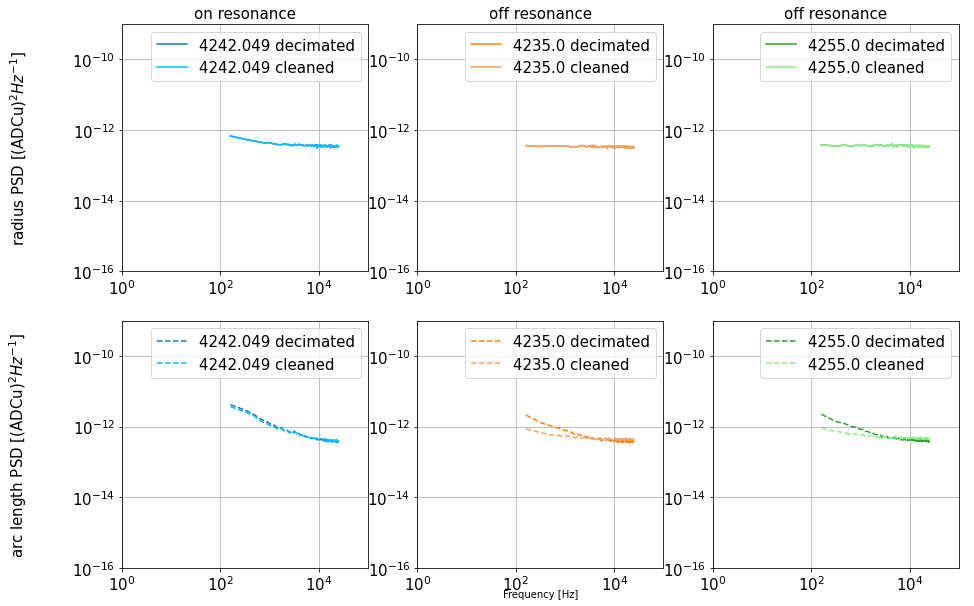

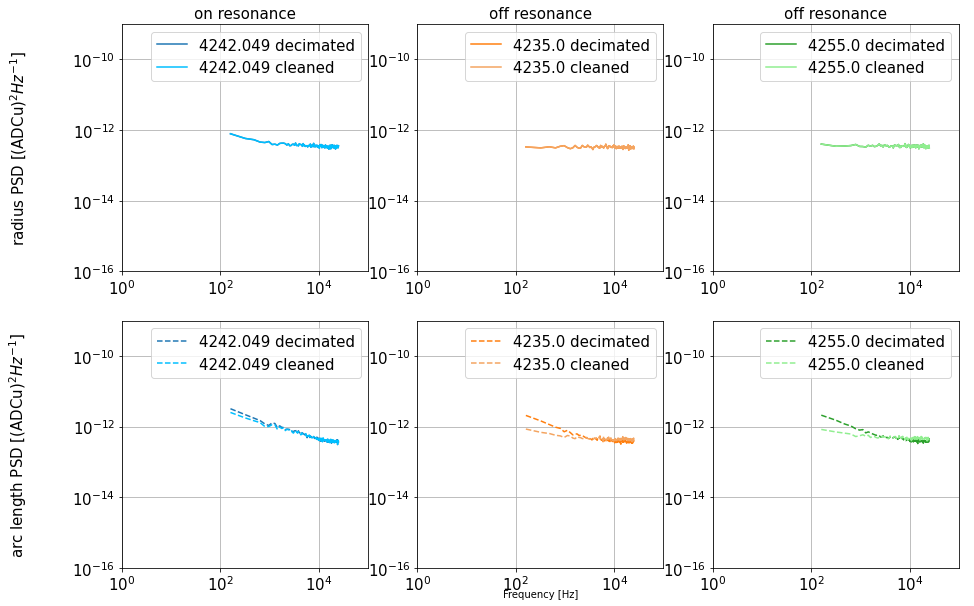

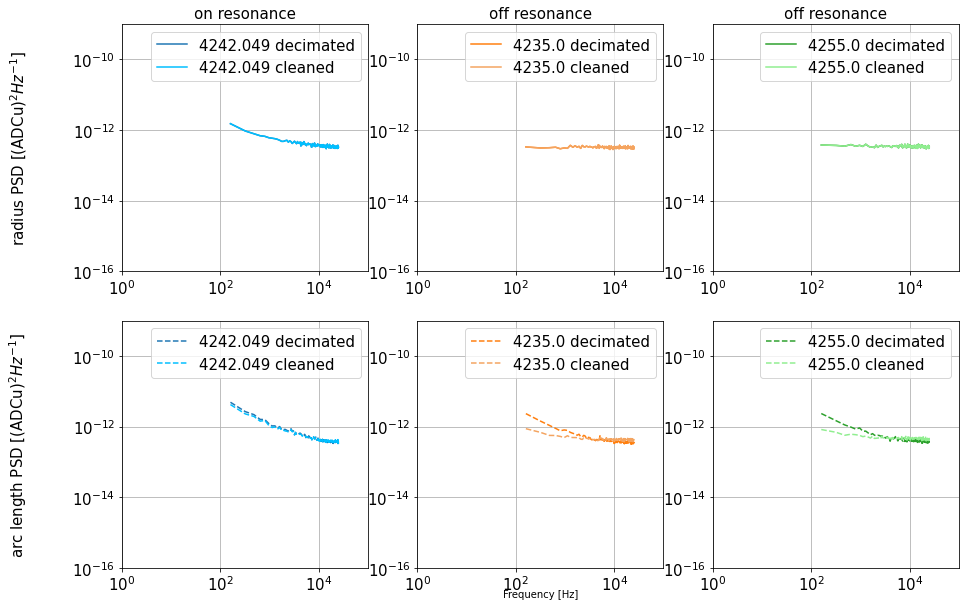

In [13]:
show_plots = False

## Options
verbose = False 

## Window selection for pulse-free region
window_shift_seconds = -8.0e-3

## Non-LED pulse removal
# stdev_cut = 0.9
# bad_pls_obj = np.empty( len(led_files[files_to_skip::2]), dtype=object )

j = 0
for pulse_file in LED_files:
    print('===================')
    print('cleaning pulse file:',pulse_file)
    print('using VNA file:     ',vna_file)
    print('using noise file:   ',nse_files[0])
    noise_file = nse_files[0]

    ## Determine how much additional decimation to apply
    pulse_noise, pulse_info = PUf.unavg_noi(pulse_file)
    pulse_fs = 1./pulse_info['sampling period']
    pulse_cleaning_decimation = int(pulse_fs/decimate_down_to)

    if verbose:
        print('loaded pulse data')

    ## Get the decimated timestream and frequency step
    pulse_noise = Prf.average_decimate(pulse_noise,pulse_cleaning_decimation)
    pulse_fs   /= pulse_cleaning_decimation

    if verbose:
        print('decimated data by ' + str(pulse_cleaning_decimation) + ' to achieve requested upper bound of ' + '{:2e}'.format(decimate_down_to) + ' Hz' )

    ## Create a new array of of frequency space with the applied decimation
    sampling_rate = pulse_fs
    samples_per_pulse = int(time_btw_pulse*sampling_rate)
    N = int(samples_per_pulse / 2) ## We look at the second half of a pulse window only
    T = N/sampling_rate
    t,f = Prf.build_t_and_f(N,sampling_rate)
    
    if verbose:
        print("Sampling rate:",sampling_rate,"per sec")
        print("Samples per pulse window:",samples_per_pulse)
        print("N=:",N,"; T=",T,";",np.shape(f))
    
    ## Define the regions where pulses exist
    ## =====================================
    
    ## This defines where (in # of pulse windows) to start looking for pulses
    pulse_start = int(total_pulses * blank_fraction)
    if verbose:
        print("Starting pulse partitioning after", pulse_start, "windows (of",total_pulses,")")
    
    ## How many samples to shift the pulse window definition
    window_shift = int(window_shift_seconds * sampling_rate)
    if verbose:
        print("Shifting pulse window by", window_shift, "samples")
    
    ## Create empty arrays to store our results in
    noise_averages = np.zeros((3),dtype=np.complex128)
    J_r = np.zeros((N,3)); J_arc = np.zeros((N,3))
    
    ## Create empty arrays to store values for histograms
    bl_means = np.array([],dtype=np.complex128)
    bl_sdevs = np.array([],dtype=np.complex128)
    
    ## Create a plot to store waveforms
    if show_plots:
        fi0 = plt.figure(pulse_file+"_a")
        ax0 = fi0.gca()
        ax0.set_xlabel("Sample")
        ax0.set_ylabel(r"$\log_{10}|S_{21}|$")
        ax0.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
        
        fi1 = plt.figure(pulse_file+"_b")
        ax1 = fi1.gca()
        ax1.set_xlabel(r"$\Re(S_{21})$")
        ax1.set_ylabel(r"$\Im(S_{21})$")
        ax1.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
        
#     ## Create a bad pulse window index array
#     bad_pulses = np.array([])
#     pulse_bad  = False

    ## Count how many good pulses there are
    n_good_pulses = num_pulses - len(bad_pls_idxs[pulse_file])
    
    ## Start the loop over pulse windows
    k=0
    for pulse_i in range(pulse_start,int(total_pulses),1):
        
        ## Skip the bad pulse windows
        if k in bad_pls_idxs[pulse_file]:
            ## Increment the counter
            k += 1
            continue
        
        ## Define the sample index where this pulse window ends
        pulse_i_end = int((pulse_i+1)*samples_per_pulse)
        
        ## Define the start of the pulse free region (period after pulse, before the next one, where it should be baseline noise)
        no_pulse_idx_start = pulse_i_end + window_shift - N 
        
        ## Define the end of the window (where the pulse-free region ends)
        no_pulse_idx_end   = pulse_i_end + window_shift
        
        ## Grab the timestream in that region and average it
        no_pulse_chunk = pulse_noise[no_pulse_idx_start:no_pulse_idx_end,:]
        
        ## Calculate some means and stdevs of this pulse-free timestream
        m = np.mean(no_pulse_chunk,axis=0,dtype=np.complex128) ; bl_means = np.append(bl_means,m[0])
        s = np.std( no_pulse_chunk,axis=0,dtype=np.complex128) ; bl_sdevs = np.append(bl_sdevs,s[0])
#         rms = np.sqrt(m*m + s*s)
        
#         ## Check the maximum value in this pulse free region
#         mx = np.abs(np.max(np.log10(abs(no_pulse_chunk[:,0]))))
#         z  = np.abs((mx-np.log10(abs(m[0]))))/np.abs(np.log10(abs(s[0])))
        
#         if (pulse_bad):
#             bad_pulses = np.append(bad_pulses, pulse_i)
#             pulse_bad  = False
#             continue
        
#         if (z > stdev_cut):
# #             print("!! -->",pulse_file, pulse_i, z)
# #             ax0.plot(np.log10(abs(no_pulse_chunk[:,0])),alpha=0.25)
#             bad_pulses = np.append(bad_pulses, pulse_i)
#             pulse_bad  = True
#             continue
        
        ## Keep a running average of the noise across all pulse regions
        noise_averages += m / n_good_pulses    
        
        ## Plot the pulse free region against time
        if show_plots: # and (k==0):
            ax0.plot(np.log10(abs(no_pulse_chunk[:,0])),alpha=0.25)
            ax1.scatter(no_pulse_chunk[:,0].real,no_pulse_chunk[:,0].imag,alpha=0.25)

        ## Convert to the electronics basis and compute the J objects
        r_chunk,arc_chunk,_,_= Prf.electronics_basis(no_pulse_chunk)
        J_r += abs(Prf.discrete_FT(r_chunk))**2 / n_good_pulses * 2 * T
        J_arc += abs(Prf.discrete_FT(arc_chunk))**2 / n_good_pulses * 2 * T
#         J_r += abs(Prf.discrete_FT(r_chunk))**2  * 2 * T
#         J_arc += abs(Prf.discrete_FT(arc_chunk))**2  * 2 * T
        
        ## Increment the counter
        k += 1
    
#     noise_averages = noise_averages / k  
#     J_r   = J_r   / k
#     J_arc = J_arc / k
    
#     bad_pls_obj[j] = bad_pulses
    
    if verbose:
        print("Searched",n_good_pulses,"pulse windows")
        print('used ' + str(n_good_pulses) + ' chunks to find quiescent point')
    
    if show_plots:
        ax0.axhline(y=np.log10(abs(noise_averages[0])),color="k",ls='--')
        
        fi2 = plt.figure(pulse_file+"_c")
        ax2 = fi2.gca()
        ax2.hist(np.log10(abs(bl_means)))
        ax2.set_xlabel(r"Pre-trigger BL mean $\log_{10}(|S_{21}|)$")
        ax2.set_ylabel("Occurences")
        ax2.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
        
        fi3 = plt.figure(pulse_file+"_d")
        ax3 = fi3.gca()
        ax3.hist(np.log10(abs(bl_sdevs)))
        ax3.set_xlabel(r"Pre-trigger BL sdev $\log_{10}(|S_{21}|)$")
        ax3.set_ylabel("Occurences")
        ax3.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
    
#     if j % 4 == 0:
#         fig, ax = plt.subplots(1,2,figsize=(5,10))
#         ax[0].plot(f[f>0],J_r[f>0],color='C'+str(j%10))
#         ax[1].plot(f[f>0],J_arc[f>0],color='C'+str(j%10))
#         ax[0].set_yscale('log'); ax[0].set_xscale('log'); ax[1].set_yscale('log'); ax[1].set_xscale('log')

    ## Pull the two real quantities from the complex timestream averages
    radius_averages = abs(noise_averages)
    angle_averages  = np.angle(noise_averages)
    if verbose:
        print(radius_averages)
        print(angle_averages)

    ## Rotate the timestream by the averange angle, then get the rotated phase timestream
    pulse_timestream_rotated = pulse_noise*np.exp(-1j*angle_averages)
    angle_timestream = np.angle(pulse_timestream_rotated)

    ## Subtract off the average magnitude value and calculate an arc length
    radius = abs(pulse_noise) - radius_averages
    arc    = angle_timestream*radius_averages

    ## Create output containers for the clean timestreams
    radius_clean = np.zeros(radius.shape)
    arc_clean    = np.zeros(arc.shape)

    if verbose:
        print('built radius and arc length timestreams given by quiescent point')
        print(noise_file)
        
    ## Pull the dictionary containing cleaning coefficients from the noise timestream
    _,data_info = PUf.clean_noi(noise_file[:-3]+'_cleaned.h5')

    ## Loop over each tone in the radius timestream
    for t in range(radius.shape[1]):
        ## Pull the coefficients from the noise cleaning
        radius_coefficient = data_info['radius cleaning coefficient'][t]
        arc_coefficient    = data_info['arc cleaning coefficient'][t]

        ## Clean each tone with the off-resonance tones
        if t == 0:
            off_tone_idcs = [1,2]
        elif t == 1:
            off_tone_idcs = [2]
        elif t == 2:
            off_tone_idcs = [1]


        ## Perform the radius cleaning
        off_tone_radius = np.mean(radius[:,off_tone_idcs],axis=1,dtype=np.float64)
        radius_clean[:,t] = radius[:,t] - radius_coefficient*off_tone_radius

        ## Perform the arc length cleaning
        off_tone_arc = np.mean(arc[:,off_tone_idcs],axis=1,dtype=np.float64)
        arc_clean[:,t] = arc[:,t] - arc_coefficient*off_tone_arc

        if verbose: 
            print('cleaned tone ' + str(t))

    ## Subtract off the mean from cleaned radius and arc length timestreams
    radius_clean -= np.mean(radius_clean,axis=0,dtype='float64')
    arc_clean -= np.mean(arc_clean,axis=0,dtype='float64')
    
    ## Save the clean timestreams to a file
    pulse_noise_clean = Prf.save_clean_timestreams(pulse_file,\
                                                   radius_averages,\
                                                   angle_averages,\
                                                   radius_clean,\
                                                   arc_clean,\
                                                   sampling_rate,\
                                                   timestreams['radius coefficient'],\
                                                   timestreams['arc coefficient'],\
                                                   override=True)

    ## Calculate the PSDs for each of the cleaned pulses
    
    ## Create containers for our output PSDs
    J_r_clean = np.zeros((N,3)); J_arc_clean = np.zeros((N,3))
    
    ## Loop over pulses
    k = 0
    for pulse_i in range(pulse_start,int(total_pulses),1):
        ## Skip the bad pulse windows
        if k in bad_pls_idxs[pulse_file]:
            ## Increment the counter
            k += 1
            continue
        
        ## Define the sample index where this pulse window ends
        pulse_i_end = int((pulse_i+1)*samples_per_pulse) 
        
        ## Define the start of the pulse free region (period after pulse, before the next one, where it should be baseline noise)
        no_pulse_idx_start = pulse_i_end + window_shift - N 
        
        ## Define the end of the window (where the pulse-free region ends)
        no_pulse_idx_end   = pulse_i_end + window_shift
        
        ## Grab the timestream in that region
        no_pulse_chunk = pulse_noise_clean[no_pulse_idx_start:no_pulse_idx_end,:]

        ## Convert the pulse-free region to electronics basis
        r_chunk,arc_chunk,_,_= Prf.electronics_basis(no_pulse_chunk)
        
        ## Compute the PSDs
        J_r_clean += abs(Prf.discrete_FT(r_chunk))**2 / n_good_pulses * 2 * T
        J_arc_clean += abs(Prf.discrete_FT(arc_chunk))**2 / n_good_pulses * 2 * T
#         J_r_clean += abs(Prf.discrete_FT(r_chunk))**2 / k * 2 * T
#         J_arc_clean += abs(Prf.discrete_FT(arc_chunk))**2 / k * 2 * T
        
        ## Increment the counter
        k += 1


    ## Trim the output to the positive frequency region only
    J_r = J_r[f>=0]; J_r_clean = J_r_clean[f>=0]; J_arc = J_arc[f>=0]; J_arc_clean = J_arc_clean[f>=0]
    
    ## Every tenth files, show the PSDs
    if j % 10 == 0:
        print(pulse_file)
        fig_0, axes_0 = plt.subplots(2,3,sharex=True,sharey='row',figsize=(5*3,10))
        
        Prf.plot_PSDs(f[f>0],J_r,J_arc,pulse_file,\
                      ['radius','arc length'],units=['ADCu','ADCu'],savefig='electronics',\
                      data_freqs=pulse_info['search freqs'],\
                      P_1_clean=J_r_clean,P_2_clean=J_arc_clean,\
                      fig_0=fig_0,axes_0=axes_0)

    j += 1

## Pulse averaging

averaging pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.600V_20221111_110843.h5
Used 614 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.650V_20221111_110843.h5
Used 601 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.700V_20221111_110843.h5
Used 595 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.750V_20221111_110843.h5
Used 617 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.800V_20221111_110843.h5
Used 394 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.850V_20221111_110843.h5
Used 481 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_2.900V_20221111_110843.h5
Used 459 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20221111/20

<ipython-input-14-5f31afbe787c>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2)


Used 504 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_3.700V_20221111_110843.h5
Used 403 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_3.750V_20221111_110843.h5
Used 234 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_3.800V_20221111_110843.h5
Used 550 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_3.850V_20221111_110843.h5
Used 537 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_3.900V_20221111_110843.h5
Used 521 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_3.950V_20221111_110843.h5
Used 428 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_4.000V_20221111_110843.h5
Used 280 pulses to average


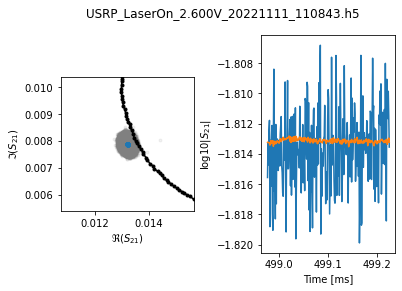

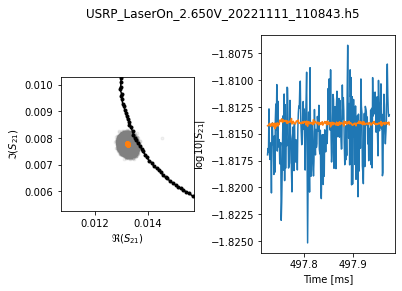

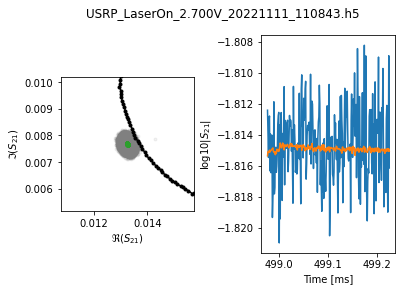

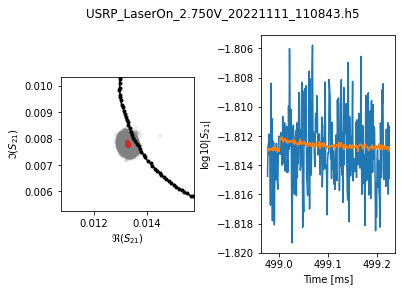

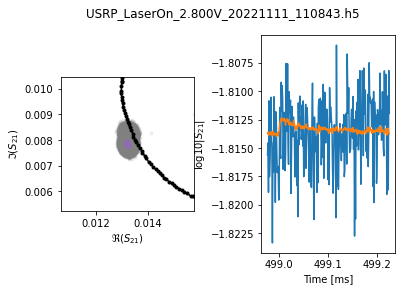

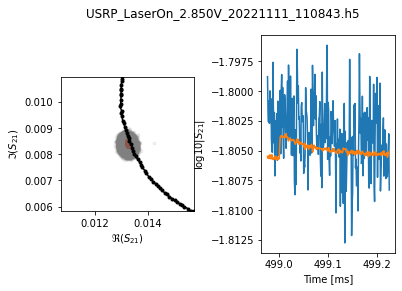

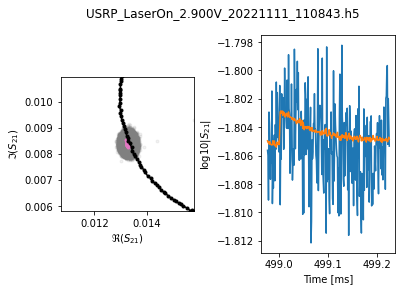

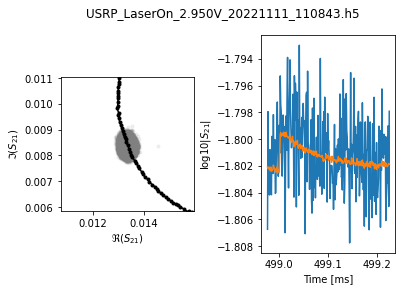

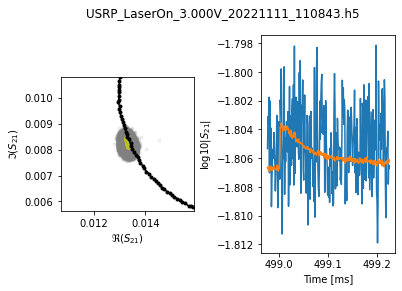

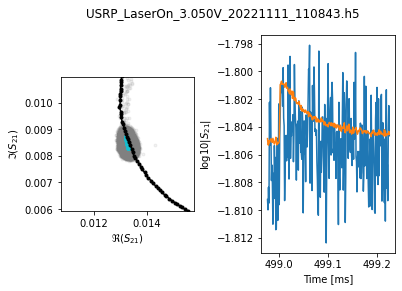

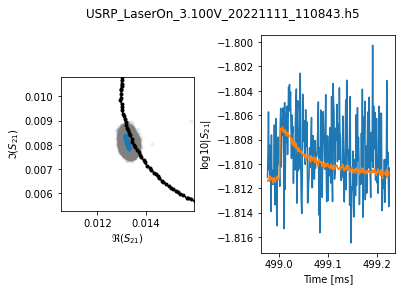

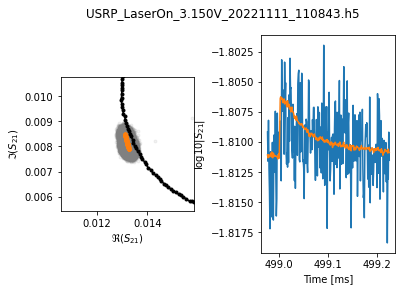

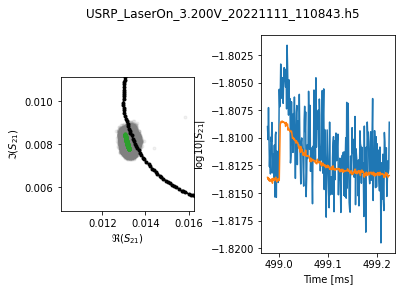

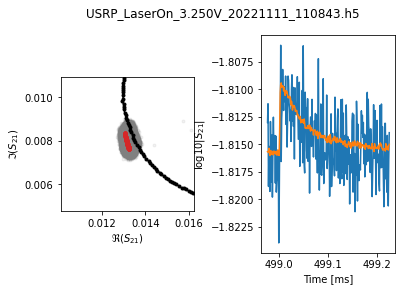

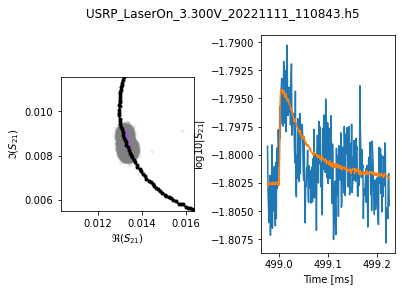

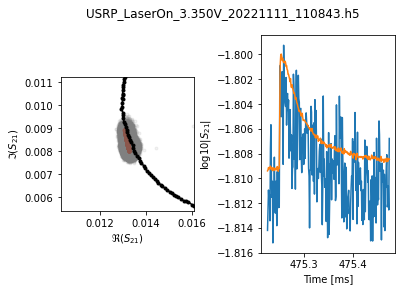

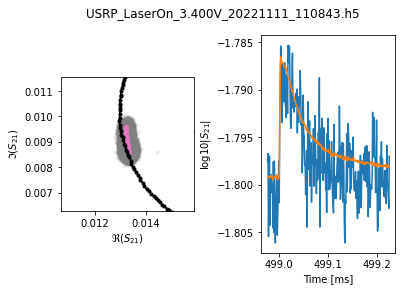

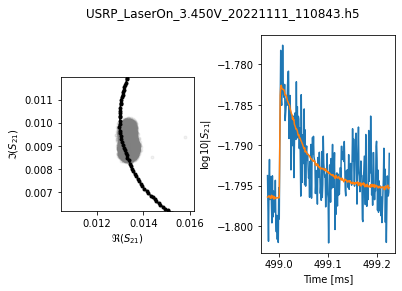

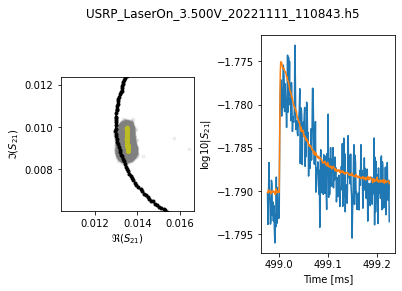

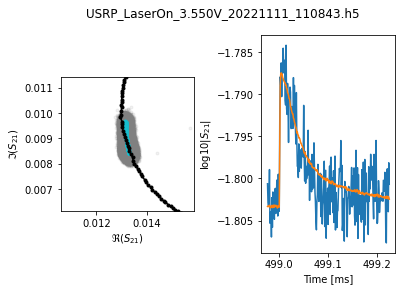

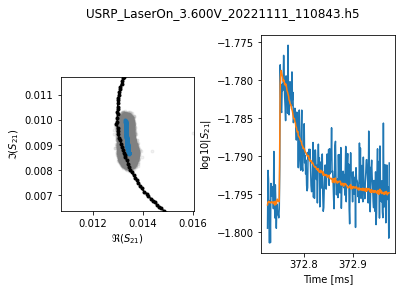

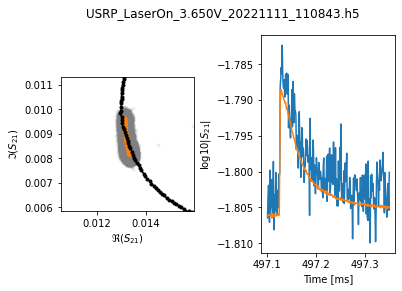

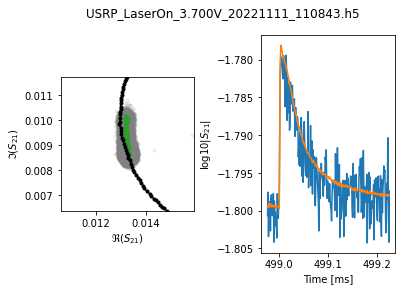

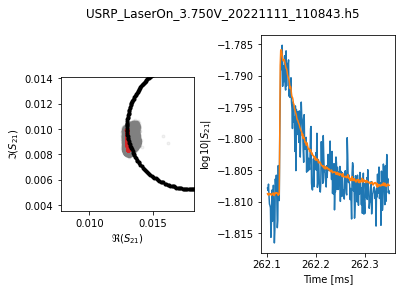

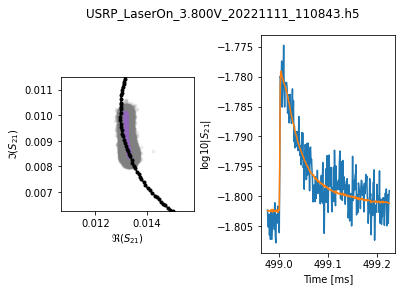

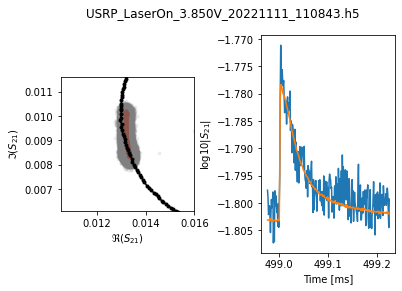

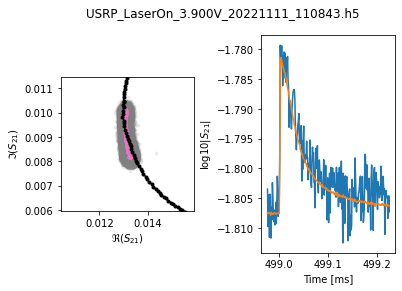

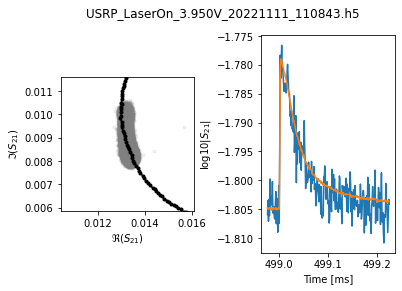

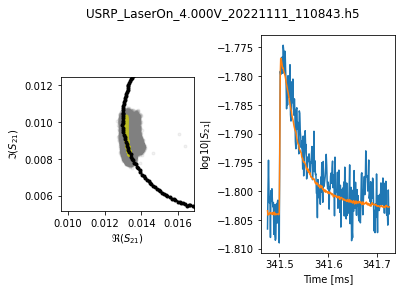

In [14]:
fraction_to_keep = (5.0/12.5) # 1.0
window_shift_seconds = -8.0e-3
verbose = False

j = 0 
for pulse_file in LED_files:
    
    ## Get the VNA data for this set of runs
    f,z = PUf.read_vna(vna_file)

    print('===================')
    print('averaging pulse file: ' + pulse_file)

    ## Load the clean pulse data
    clean_pulse_file = pulse_file[:-3] + '_cleaned.h5'
    pulse_noise_clean,data_info = PUf.clean_noi(clean_pulse_file)
    if verbose: 
        print('loaded clean pulse data')        
        print('sampling_rate: ' + str(data_info['sampling_rate']))
    
    ## Determine how many samples are in each pulse window
    samples_per_pulse = data_info['sampling_rate'] * time_btw_pulse

    ## Do extra decimation if needed (1 = no decimation) 
    decimation = 1
    time = Prf.average_decimate(pulse_info['time'],decimation)
    pulse_noise_clean = Prf.average_decimate(pulse_noise_clean,decimation)
    
    ## Update the samples per window and sampling rate with new decimation
    samples_per_pulse_decimated = int(samples_per_pulse / decimation)
    sampling_rate = data_info['sampling_rate'] / decimation
    if verbose:
        print('further decimation by ' + str(decimation) + ' complete')

    ## Create a container to store our average pulse in complex S21 for this file
    pulse_avg    = np.zeros(int(samples_per_pulse_decimated*fraction_to_keep),dtype=np.complex128)
    
    ## Determine how many samples to shift the window by
    window_shift = int(window_shift_seconds*sampling_rate)
    
    ## Identify the first pulse window after the transient period
    pulse_start  = int(total_pulses * blank_fraction)
    
    ## Count how many good pulses there are in this file
    n_good_pulses = num_pulses - len(bad_pls_idxs[pulse_file])
    
    ## Start the loop over pulse windows
    k=0
    for pulse_i in range(pulse_start,int(total_pulses),1):
        
        ## Skip the bad pulse windows
        if k in bad_pls_idxs[pulse_file]:
            ## Increment the counter
            k += 1
            continue
            
        pulse_idx_start = int(pulse_i*samples_per_pulse_decimated) + window_shift
        pulse_idx_end   = int(round((pulse_i+fraction_to_keep)*samples_per_pulse_decimated,0)) + window_shift
        
        ## Define the sample index where this pulse window ends
        pulse_idx_start = int((pulse_i  )*samples_per_pulse_decimated) + window_shift
        # pulse_idx_end   = int((pulse_i+1)*samples_per_pulse_decimated) + window_shift -1
        pulse_idx_end   = int(round((pulse_i+fraction_to_keep)*samples_per_pulse_decimated,0)) + window_shift
        
        ## Create a list of indeces corresponding to the samples in this pulse window
        pulse_idx_list = np.arange(pulse_idx_start,pulse_idx_end,1,dtype=int)
        
        ## Average the pulses in each good window
        pulse_avg += pulse_noise_clean[pulse_idx_list,0] / n_good_pulses
        
        ## Increment the counter
        k += 1
    
    ## Create a figure in complex S21 to show VNA, full timestream, and average pulse
    fig, axs = plt.subplots(1, 2)
    plt.suptitle(pulse_file.split("/")[-1])
    axs[0].set_xlabel(r"$\Re(S_{21})$")
    axs[0].set_ylabel(r"$\Im(S_{21})$")
    axs[1].set_xlabel("Time [ms]")
    axs[1].set_ylabel(r"$\log10 |S_{21}|$")
    
    axs[0].plot(pulse_noise_clean[:,0].real,pulse_noise_clean[:,0].imag,ls='',marker='.',alpha=0.1,color='grey')
    axs[0].plot(pulse_avg.real,pulse_avg.imag,color='C'+str(j % 10),ls='-',marker='.')
    axs[0].plot(z.real,z.imag,color='k',ls='-',marker='.',alpha=1.00)
    
    axs[1].plot(time[pulse_idx_list,0]*1e3,np.log10(abs(pulse_noise_clean[pulse_idx_list,0])))
    axs[1].plot(time[pulse_idx_list,0]*1e3,np.log10(abs(pulse_avg)))
    
    width = 50 * np.std(pulse_noise_clean[:,0].real)
    x_c = np.mean(pulse_avg.real)
    y_c = np.mean(pulse_avg.imag)
    axs[0].set_xlim([x_c - width/2., x_c + width/2.])
    axs[0].set_ylim([y_c - width/2., y_c + width/2.])
    axs[0].set_aspect('equal','box')
    
    plt.subplots_adjust(wspace=0.5)
    
    # plt.savefig('noise and averaged pulse.png',dpi=100)
        
    print('Used ' + str(n_good_pulses) + ' pulses to average')
    with h5py.File(clean_pulse_file, "a") as fyle:
        if 'pulse_shape' in fyle.keys():
            del fyle['pulse_shape']
            print('deleted an old pulse shape')
        fyle.create_dataset('pulse_shape',data = np.asarray(pulse_avg))
    j += 1

## Pulse rotation

cleaning pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_4.000V_20221111_110843.h5
using VNA file:      /data/USRP_Laser_Data/20221111/20221111_110843/USRP_VNA_20221111_110843.h5
using summary file:  /data/USRP_Laser_Data/20221111/20221111_110843/noise_averages_20221111_110843.h5
Fr from fit  [GHz]: 4.242049060503808
Fr min curve [GHz]: 4.242048720750536
Fr from fit  [GHz]: 4.242049060503808
Fr min curve [GHz]: 4.242048720750536
Saving clean pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_4.000V_20221111_110843_cleaned.h5
cleaning pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_3.950V_20221111_110843.h5
using VNA file:      /data/USRP_Laser_Data/20221111/20221111_110843/USRP_VNA_20221111_110843.h5
using summary file:  /data/USRP_Laser_Data/20221111/20221111_110843/noise_averages_20221111_110843.h5
Fr from fit  [GHz]: 4.242049060503808
Fr min curve [GHz]: 4.242048720750536
Fr from fit  [GHz]: 4.242049060503808
Fr mi

Saving clean pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_3.250V_20221111_110843_cleaned.h5
cleaning pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_3.200V_20221111_110843.h5
using VNA file:      /data/USRP_Laser_Data/20221111/20221111_110843/USRP_VNA_20221111_110843.h5
using summary file:  /data/USRP_Laser_Data/20221111/20221111_110843/noise_averages_20221111_110843.h5
Fr from fit  [GHz]: 4.242049060503808
Fr min curve [GHz]: 4.242048720750536
Fr from fit  [GHz]: 4.242049060503808
Fr min curve [GHz]: 4.242048720750536
Saving clean pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_3.200V_20221111_110843_cleaned.h5
cleaning pulse file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_3.150V_20221111_110843.h5
using VNA file:      /data/USRP_Laser_Data/20221111/20221111_110843/USRP_VNA_20221111_110843.h5
using summary file:  /data/USRP_Laser_Data/20221111/20221111_110843/noise_averages_20221111_110843.h5


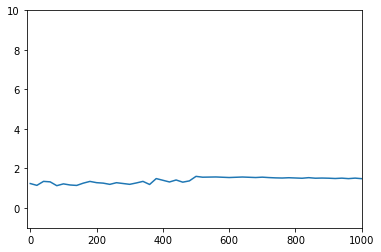

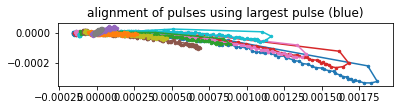

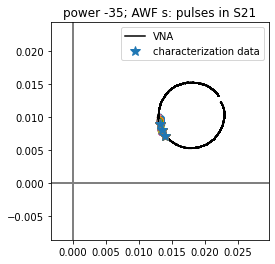

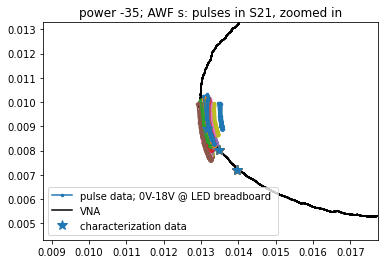

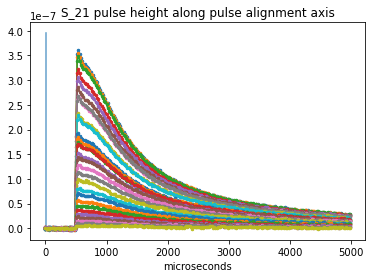

In [15]:
i = 0

time_window_range = fraction_to_keep * time_btw_pulse *1e6
time_window = np.arange(0,time_window_range,1/sampling_rate*1e6)[:-1]

tw_min = 3000 #  8000 # 200
tw_max = 4000 # 10000 # 300
# time_window = np.arange(-200,time_window_range-200,1/sampling_rate*1e6)
# time_window = np.arange(window_shift_seconds*1e6,time_window_range+window_shift_seconds*1e6,1/sampling_rate*1e6)
for pulse_file in LED_files[::-1]:
    print('===================')
    print('cleaning pulse file:',pulse_file)
    print('using VNA file:     ',vna_file)
    print('using summary file: ',sum_file)
    char_file = sum_file

    AWF_string = "10 us"
    title_1 = 'power ' + str(rf_power) + '; AWF ' + AWF_string[4:] + ': pulses in S21'
    title_1p5 = 'power ' + str(rf_power) + '; AWF ' + AWF_string[4] + ': pulses in S21, zoomed in'
    title_1p75 = 'alignment of pulses using largest pulse (blue)'
    # title_2 = 'power ' + power_directories[j][:-1] + ': timestream along rotated axis'    
    title_2 = 'S_21 pulse height along pulse alignment axis'
    clean_pulse_file = pulse_file[:-3] + '_cleaned.h5'
    with h5py.File(clean_pulse_file, "r") as fyle:
        pulse_avg = np.array(fyle["pulse_shape"],dtype=np.complex128)
        pulse_timestream = np.array(fyle["cleaned_data"],dtype=np.complex128)
#     with h5py.File(char_file,'r') as fyle:
#         char_points = np.array(fyle['means'])
#         char_f = np.array(fyle['frequencies'])
#         readout_f = char_f[0]
    readout_f = charFs[1]
    f,z = PUf.read_vna(vna_file)

    # print(pulse_fs)
    df_f, d1_Q, _, _ = Prf.resonator_basis(pulse_avg,readout_f*1e-3,f*1e-3,z,charFs*1e-3,charZs)#,plot_title='power ' + power_directories[j][:-1] + ' AWF ' + AWF_string)
    df_f_timestream, d1_Q_timestream, _, _ = Prf.resonator_basis(pulse_timestream[:,0],readout_f*1e-3,f*1e-3,z,charFs*1e-3,charZs)
    # plt.axis([0.058, 0.062, -0.19, -0.15])

    pulse_avg_mb = pulse_avg - np.mean(pulse_avg[-5:],dtype=np.complex128)
    std = np.std(abs(pulse_avg_mb[-5:]),dtype=np.complex128)
    # average_angle = np.mean(np.angle(pulse_avg_mb[abs(pulse_avg_mb) > 5*std]))
    # average_angle = np.mean(np.angle(pulse_avg_mb[abs(pulse_avg_mb[time_window > 200]) > 5*std]))
    average_angle = np.mean(np.angle(pulse_avg_mb[np.logical_and(time_window>tw_min,time_window<tw_max)]))
    pulse_timestream_mb = pulse_timestream[:,0] - np.mean(pulse_avg[-5:],dtype=np.complex128)

    pulse_avg_rotated = pulse_avg_mb * np.exp(-1j*average_angle)
    pulse_timestream_rotated = pulse_timestream_mb * np.exp(-1j*average_angle)

    ## Subtract off the mean
#     template = df_f - np.mean(df_f[-100:])
#     noise = df_f_timestream - np.mean(df_f[-100:])
    
    template = df_f - np.mean(df_f[:20])
    noise = df_f_timestream - np.mean(df_f[:20])

#     template = pulse_avg_rotated.real #pulse_avg_rotated.real
#     noise = pulse_timestream_rotated.real
#     print(np.shape(pulse_avg),np.shape(df_f))

    with h5py.File(clean_pulse_file, "a") as fyle:
        print("Saving clean pulse file:",clean_pulse_file)
        if 'df_f_template' in fyle.keys():
            del fyle['df_f_template']
        if 'df_f_pulse_noise' in fyle.keys():
            del fyle['df_f_pulse_noise']
        fyle.create_dataset('df_f_template',data = np.asarray(template))
        fyle.create_dataset('df_f_pulse_noise',data = np.asarray(noise))
    if i % 1 == 0:
        label_c = 'characterization data' if i == 0 else None
        label_V = 'VNA' if i == 0 else None
        label_p = 'pulse data; 0V-18V @ LED breadboard ' if i == 0 else None
        plt.figure(title_1)
        plt.plot(pulse_avg.real,pulse_avg.imag,ls='-',marker='.',markersize=5,color='C'+str(i%10))
        plt.plot(z.real,z.imag,color='k',label=label_V)
        plt.plot(charZs.real,charZs.imag,marker='*',markersize=10,ls='',label=label_c,zorder=-5*i+200)
        plt.axhline(0,color='grey')
        plt.axvline(0,color='grey')
        plt.title(title_1)
        width = 8e3 * np.std(pulse_avg.real)
        x_c = np.mean(pulse_avg.real)
        y_c = np.mean(pulse_avg.imag)
        plt.axis([x_c - width/2., x_c + width/2., y_c-width/2., y_c+width/2.])
        ax = plt.gca()
        ax.set_aspect('equal','box')
        plt.legend()

        plt.figure(title_1p5)
        plt.plot(pulse_avg.real,pulse_avg.imag,ls='-',marker='.',markersize=5,color='C'+str(i%10),label=label_p,zorder=-5*i+200)
        plt.plot(z.real,z.imag,color='k',label=label_V)
        plt.plot(charZs.real,charZs.imag,marker='*',markersize=10,ls='',label=label_c,zorder=-5*i+200)
        plt.title(title_1p5)

        if i == 0:
            width = 150 * np.std(pulse_avg.real)
            x_c = np.mean(pulse_avg.real)
            y_c = np.mean(pulse_avg.imag)
            plt.axis([x_c - width/2., x_c + width/2., y_c-width/2., y_c+width/2.])
            plt.legend()
        # plt.axis([0.055,0.06,-0.175,-0.17])
        # plt.axis([-0.025,-0.023,-0.031,-0.029])
        # plt.savefig('power_' + power_directories[j][:-1] + '_AWF_' + NDF_directories[i][:-1] + '_S21_100mK.png')

        if i % 3 == 0:
            plt.figure(title_1p75)
            plt.plot(pulse_avg_rotated.real,pulse_avg_rotated.imag,ls='-',marker='.',markersize=5,color='C'+str(i%10))
            ax = plt.gca()
            ax.set_aspect('equal', 'box')
            plt.title(title_1p75)



    AWF_idx = AWF_string.find('us')
    width = float(AWF_string[AWF_idx-3:AWF_idx])
    plt.figure(title_2)
    radius, arc_length, _, _ = Prf.electronics_basis(pulse_avg)
    # pulse_avg_plot = arc_length
    # pulse_avg_plot = pulse_avg.imag - np.mean(pulse_avg[:20].imag)
    pulse_avg_plot = template

    plt.plot(time_window,pulse_avg_plot,ls='-',marker='.',markersize=5,color='C'+str(i))
    if i == 0:
        plot_max = max(pulse_avg_plot)
        ax = plt.gca()
        ax.add_patch(mpatches.Rectangle((0,0),width,plot_max*1.1,alpha=0.4,color='C'+str(i)))
#     plt.xlim([window_shift_seconds-10, 1000])
    plt.xlabel('microseconds')
    plt.title(title_2)
    # plt.ylim([-4e-7,4e-7])

    if i == 0:
        stored_pulse = pulse_avg_rotated.real
    elif i == 8:
        current_pulse = pulse_avg_rotated.real
        ratio = stored_pulse / current_pulse
        plt.figure('ratio of pulses')
#         plt.title('ratio of pulses')
        plt.plot(time_window,ratio)
        plt.xlim([-10, 1000])
        plt.ylim([-1,10])


    # plt.savefig('power_' + power_directories[j][:-1] + '_d1_Q_100mK.png')
    i += 1
    
# directory = "/data/ProcessedOutputs/out"+series
# plt.figure(title_1)
# plt.savefig(directory + 'VNA_char_pulse_S21.png',dpi=300,facecolor='white',transparent=False)
# plt.figure(title_1p5)
# plt.savefig(directory + 'VNA_char_pulse_S21_zoomed_in.png',dpi=300,facecolor='white',transparent=False)
# plt.figure(title_1p75)
# plt.savefig(directory + 'pulse_alignment.png',dpi=300,facecolor='white',transparent=False)
# plt.figure(title_2)
# plt.savefig(directory +'timestream_aligned',dpi=300,facecolor='white',transparent=False)

## Optimal Filter code

### OF Window parameter definitions

In [16]:
## Number of seconds by which to shift the window when calculating J
window_shift_J = -8.0e-3 # -10e-6 #

## Define a maximum frequency for the fourier-space mask
f_max = 1e4 ## Hz maximum freq in fourier space

## Create titles for the plots
title      = 'readout power ' + str(rf_power) + ': '

## Create a colormap for plotting different LED powers
cmap   = plt.get_cmap('OrRd')

### Determine the signal template

Using file: /data/USRP_Laser_Data/20221111/20221111_110843/USRP_LaserOn_4.000V_20221111_110843.h5 as pulse template
250 samples per window
(0.9350517348309145, 0.06494826516908546)


<IPython.core.display.Javascript object>


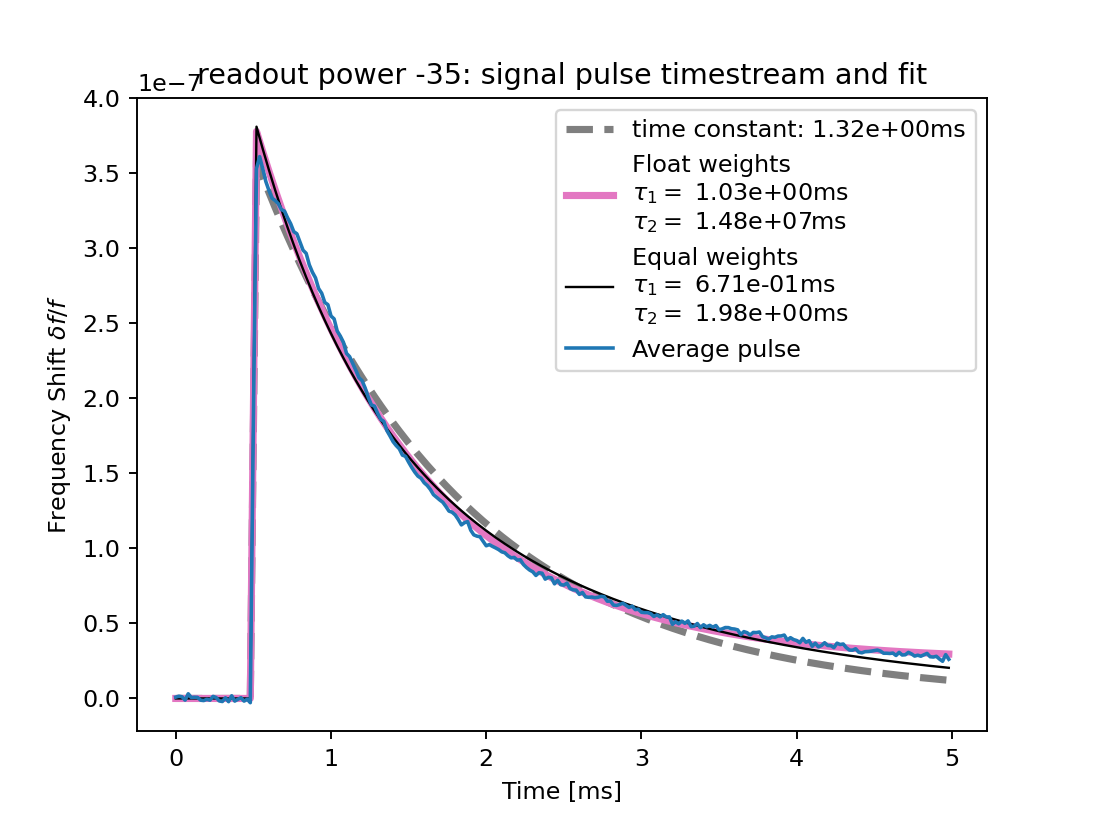

<IPython.core.display.Javascript object>


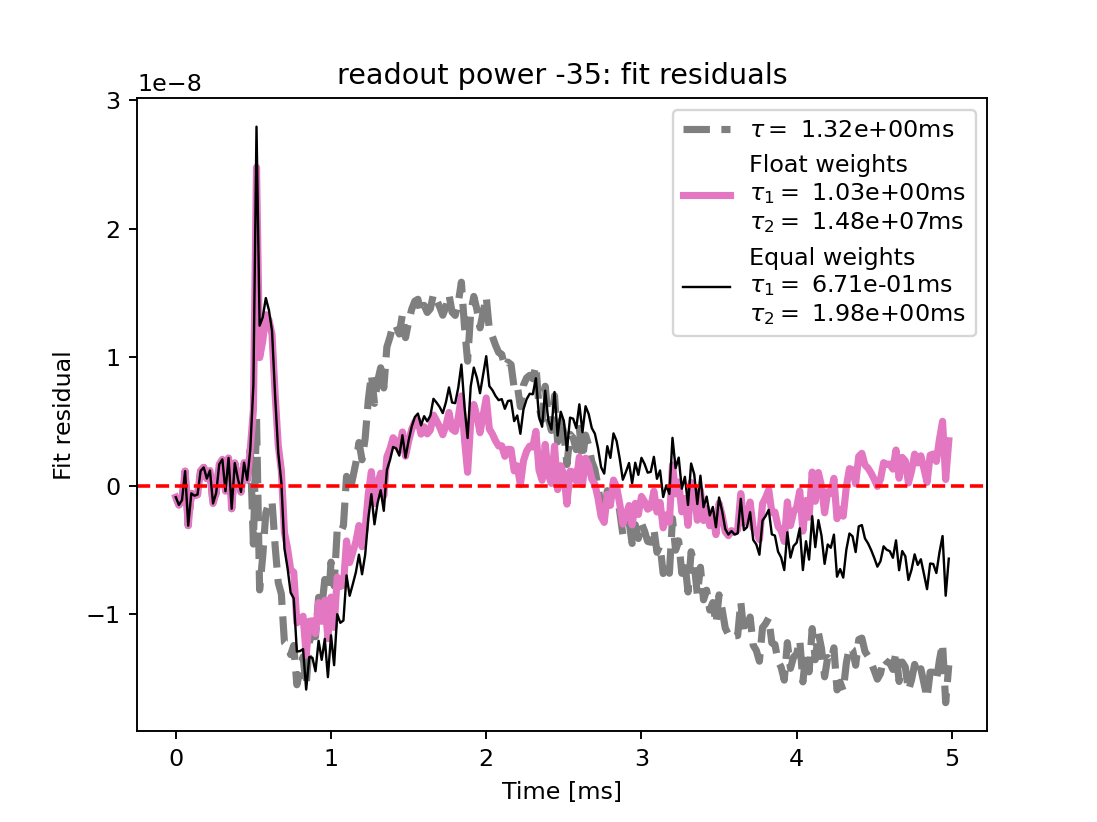

In [59]:
%matplotlib notebook
## Pick the highest LED voltage data to use as signal template
pls_file_template = LED_files[-1]
print("Using file:",pls_file_template,"as pulse template")

## Find the clean pulse file, use the last one in the set that's been analyzed so far
clean_pulse_file = pls_file_template[:-3] + '_cleaned.h5'

## Open the cleaned data and pull the data sampling rate, pulse template, and pulse noise
with h5py.File(clean_pulse_file, "r") as fyle:
    sampling_rate = np.array(fyle['sampling_rate'])
    pulse_avg     = np.array(fyle["df_f_template"])

## Determine a window size equivalent to the full pulse template window
N = len(pulse_avg)
print(N, "samples per window")

## Determine total period of the template and create a time-domain array and a freq-domain array
T = N/sampling_rate
time, f = Prf.build_t_and_f(N,sampling_rate)

## Define an offset function to recenter the pulse
t_offset = lambda N: int(N * (0.5/5.0))

## Define an exponential function
exponential = lambda x, A, tau: np.heaviside(x-time[t_offset(N)],0.5) * A * np.exp(-1*(x-time[t_offset(N)])/tau)
dbl_expA    = lambda x, A, t1, t2: np.heaviside(x-time[t_offset(N)],0.5) * A * ( np.exp(-1*(x-time[t_offset(N)])/t1) + np.exp(-1*(x-time[t_offset(N)])/t2) )
dbl_expB    = lambda x, A1, A2, t1, t2: np.heaviside(x-time[t_offset(N)],0.5) * ( A1*np.exp(-1*(x-time[t_offset(N)])/t1) + A2*np.exp(-1*(x-time[t_offset(N)])/t2) )

## Fit the average pulse to an exponential
popt, pcov  = curve_fit(exponential,time,pulse_avg,p0=[5.0e-7,       1.24e-3])
popt2,pcov2 = curve_fit(dbl_expA,time,pulse_avg   ,p0=[5.0e-7,       1.24e-3/5.,1.24e-3*5.])
popt3,pcov3 = curve_fit(dbl_expB,time,pulse_avg   ,p0=[2.5e-7,2.5e-7,1.24e-3/5.,1.24e-3*5.])
Aweights = ( popt3[0]/(popt3[0]+popt3[1]) , popt3[1]/(popt3[0]+popt3[1]) )
print(weights)
    
## Calculate the best fit curve for the average pulse
pulse_fit  = exponential(time,*popt)
pulse_fit2 = dbl_expA(time,*popt2)
pulse_fit3 = dbl_expB(time,*popt3)
    
## Get the frequency space of the average pulse
s_temp = Prf.discrete_FT(pulse_avg)
    
## Numerically integrate the fit, then FT it
A = np.trapz(pulse_fit,dx = time[1]-time[0])
s = Prf.discrete_FT(pulse_fit)

## Define a mask for evaluating fourier space components
f_mask = np.logical_and(f <= f_max, f >= -1*f_max)
N_mask = len(f[f_mask])
f_plot = np.logical_and(f > 0, f <= f_max)
new_fs = max(f[f_mask])

## Get the magnitude of s^2 for the masked region
S_mag = abs(s[f_mask]**2)

## Create a plot to store the template waveform and best fit
f1p5  = plt.figure()
ax1p5 = f1p5.gca()
ax1p5.plot(time*1e3,pulse_fit, 'C7',linewidth=3,label='time constant: {:.2e}ms'.format(popt[-1]*1e3), ls='--' )
ax1p5.plot(time*1e3,pulse_fit3,'C6',linewidth=3,label='Float weights\n'+r'$\tau_1=$ {:.2e}ms'.format(popt3[-2]*1e3)+"\n"+r'$\tau_2=$ {:.2e}ms'.format(popt3[-1]*1e3))
ax1p5.plot(time*1e3,pulse_fit2,'k' ,linewidth=1,label='Equal weights\n'+r'$\tau_1=$ {:.2e}ms'.format(popt2[-2]*1e3)+"\n"+r'$\tau_2=$ {:.2e}ms'.format(popt2[-1]*1e3))
ax1p5.plot(time*1e3,pulse_avg, label="Average pulse")
ax1p5.set_title(title + 'signal pulse timestream and fit')
ax1p5.set_xlabel("Time [ms]")
ax1p5.set_ylabel(r"Frequency Shift $\delta f / f$")
plt.legend()


f1p7  = plt.figure()
ax1p7 = f1p7.gca()
ax1p7.plot(time*1e3,pulse_fit -pulse_avg,'C7',linewidth=3,label=r'$\tau=$ {:.2e}ms'.format(popt[-1]*1e3) , ls='--' )
ax1p7.plot(time*1e3,pulse_fit3-pulse_avg,'C6',linewidth=3,label='Float weights\n'+r'$\tau_1=$ {:.2e}ms'.format(popt3[-2]*1e3)+"\n"+r'$\tau_2=$ {:.2e}ms'.format(popt3[-1]*1e3))
ax1p7.plot(time*1e3,pulse_fit2-pulse_avg,'k' ,linewidth=1,label='Equal weights\n'+r'$\tau_1=$ {:.2e}ms'.format(popt2[-2]*1e3)+"\n"+r'$\tau_2=$ {:.2e}ms'.format(popt2[-1]*1e3))
ax1p7.axhline(y=0,color='r',ls='--')
ax1p7.set_title(title + 'fit residuals')
ax1p7.set_xlabel("Time [ms]")
ax1p7.set_ylabel("Fit residual")
plt.legend()

### Determine the noise template

In [ ]:
## Pick the lowest LED voltage data to use as noise template
nse_file_template = LED_files[0]
print("Using file:",nse_file_template,"to characterize noise")

## Find the clean noise file, use the last one in the set that's been analyzed so far
clean_noise_file = nse_file_template[:-3] + '_cleaned.h5'

## Open the cleaned data and pull the data sampling rate, pulse template, and pulse noise
with h5py.File(clean_noise_file, "r") as fyle:
    sampling_rate = np.array(fyle['sampling_rate'])          
    pulse_noise   = np.array(fyle["df_f_pulse_noise"])

## Determine total period of the template and create a time-domain array and a freq-domain array
T = N/sampling_rate
time, f = Prf.build_t_and_f(N,sampling_rate)

## Determine how many samples to shift the window when calculating J
samples_per_pulse  = sampling_rate*time_btw_pulse
window_shift_J_idx = int(window_shift_J*sampling_rate)
    
## Create a container to store J in temporarily
J = np.zeros(N)
    
## Count how many good pulses there are in this file
n_good_pulses = num_pulses - len(bad_pls_idxs[pulse_file])

## Loop over all the pulse windows in the file
## We want to skip the windows cut out when finding noise free region
k = 0
for pulse_i in range(pulse_start,int(total_pulses),1):

    ## Skip the bad pulse windows
    if k in bad_pls_idxs[pulse_file]:
        ## Increment the counter
        k += 1
        continue

    ## Find the index for the end of this pulse window
    pulse_i_end = int((pulse_i+1)*samples_per_pulse) 

    ## Apply the window shift and an array of samples for the window timestream points
    ## Are we really trying to find a pulse free region? seems like it
    no_pulse_idx_start = pulse_i_end + window_shift_J_idx - N
    no_pulse_idx_end   = pulse_i_end + window_shift_J_idx
    no_pulse_idx_list  = np.arange(no_pulse_idx_start,no_pulse_idx_end,1,dtype=int)
    no_pulse_noise_i   = pulse_noise[no_pulse_idx_list]

    ## Caclulate the average J for this region
    J += abs(Prf.discrete_FT(no_pulse_noise_i))**2 / n_good_pulses * 2 * T

    ## Increment the counter
    k += 1
    
## Determine the average J for plotting
J_avg = np.mean(J)

## Calculate the denominator for the optimal filter
denominator = np.sum(abs(s[f_mask])**2/J[f_mask])

## Calculate the baseline resolution
b7_res = np.sqrt(((2*T*denominator)**-1))
print("Baseline resolution:", b7_res)

## Plot the J we'll use for optimal filtering
f2p0  = plt.figure()
ax2p0 = f2p0.gca()
plt.plot(f[f_plot],J[f_plot],zorder=-5*j+5,color='k')
ax2p0.set_title(title + 'noise frequeny domain')
ax2p0.set_xlabel("Frequency [Hz]")
ax2p0.set_xlabel(r"$J$")
ax2p0.set_xscale('log')
ax2p0.set_yscale('log')
ax2p0.set_ylim([1e-1*J_avg,1e2*J_avg])

In [ ]:
verbose = False

## Create titles for the plots
title      = 'readout power ' + str(rf_power) + ': '
title_1    = title + 'signal template'
title_2    = title + 'noise power spectral density'
title_2    = 'noise power spectral densities'
title_2p2  = 'noise power spectral densities at lowest F'
title_2p1  = 'examples of V in time'
title_2p5  = 'index of IFFT with peak value'
title_3    = title + 'histogram of pulse heights'
title_4    = title + 'sigma vs mu'

## Something to do about time offset between pulse window and singal template
offset_exponent = np.zeros((N_mask,N_mask),dtype=np.complex128)
time_ds = np.linspace(0,(N_mask-2)/(2*new_fs),N_mask)
print((N_mask-1)/(2*new_fs))
for j in range(N_mask):
    offset_exponent[j,:] = np.exp(1j*2*np.pi*f[f_mask][j]*time_ds)

for j in range(N_mask):
    for k in range(N_mask):
        if abs(offset_exponent[j,k].real) < 1e-10:
            offset_exponent[j,k] = 1j*offset_exponent[j,k].imag
        if abs(offset_exponent[j,k].imag) < 1e-10:
            offset_exponent[j,k] = offset_exponent[j,k].real

## Containers for ...
mu    = np.zeros(N_mask)
sigma = np.zeros(N_mask)

## Create containers to hold the means and standard deviations for the pulse height distribution
## for each of the pulse files
mus    = []
sigmas = []
J_at_min_f = np.array([])

## Start a loop over pulse files
j = 0
for pulse_file in LED_files[::-1]:
    if verbose: 
        print('=====================')
        print('analyzing data file: ' + pulse_file, "VLED=",Voltages[::-1][i])
    
    color = cmap( (Voltages[::-1][j]-np.min(Voltages)) / (np.max(Voltages)-np.min(Voltages)) ) # 'C'+str(j%10)
    
    ## Pull the average pulse and pulse PSDs from the cleaned pulse data file
    clean_pulse_file = pulse_file[:-3] + '_cleaned.h5'
    with h5py.File(clean_pulse_file, "r") as fyle:
        pulse_avg = np.array(fyle["df_f_template"])            
        pulse_noise = np.array(fyle["df_f_pulse_noise"])

    ## Recenter the average pulse
    pulse_recentered = pulse_avg # np.concatenate((pulse_avg[t_offset(N):],pulse_avg[:t_offset(N)]))
    
    ## Fit the average pulse to an exponential
    popt,pcov = curve_fit(exponential,time,pulse_recentered,p0=[1.2e-4,50e-6])
    
    ## Calculate the best fit curve for the average pulse
    pulse_fit = exponential(time,*popt)
    
    ## Get the frequency space of the average pulse
    s_temp = Prf.discrete_FT(pulse_recentered)
    
    ## Create a plot and store the signal template in f-space
    if j == 0:
        plt.figure(title_1)
        plt.plot(f[f_plot],abs(s[f_plot]**2),zorder=-5*j+5,color='k',linewidth=3)
        
    ## Focus the plot already containing the signal template, draw the average pulse for this file
    plt.figure(title_1)
    plt.plot(f[f_plot],abs(s_temp[f_plot]**2),zorder=-5*j+5,color=color)

    ## Determine how many samples to shift the window when calculating J
    samples_per_pulse  = sampling_rate*time_btw_pulse
    window_shift_J_idx = int(window_shift_J*sampling_rate)
    
    ## Create a container to store J in temporarily
    J_temp = np.zeros(N)
    
    ## Count how many good pulses there are in this file
    n_good_pulses = num_pulses - len(bad_pls_idxs[pulse_file])

    ## Loop over all the pulse windows in the file
    ## Do we want to skip the windows cut out when finding average pulse? probably
    k = 0
    for pulse_i in range(pulse_start,int(total_pulses),1):
        
        ## Skip the bad pulse windows
        if k in bad_pls_idxs[pulse_file]:
            ## Increment the counter
            k += 1
            continue
        
        ## Find the index for the end of this pulse window
        pulse_i_end = int((pulse_i+1)*samples_per_pulse) 
        
        ## Apply the window shift and an array of samples for the window timestream points
        ## Are we really trying to find a pulse free region? seems like it
        no_pulse_idx_start = pulse_i_end + window_shift_J_idx - N
        no_pulse_idx_end   = pulse_i_end + window_shift_J_idx
        no_pulse_idx_list  = np.arange(no_pulse_idx_start,no_pulse_idx_end,1,dtype=int)
        no_pulse_noise_i   = pulse_noise[no_pulse_idx_list]
        
        ## Caclulate the average J for thid region
        J_temp += abs(Prf.discrete_FT(no_pulse_noise_i))**2 / n_good_pulses * 2 * T
        # J_temp += abs(fft.ifft(no_pulse_noise_i))**2 / num_pulses * 2 * T
        
        ## Increment the counter
        k += 1
        
    ## Plot the average J for this pulse file
    plt.figure(title_2)
    plt.plot(f[f_plot],J_temp[f_plot],zorder=-5*j+5,color=color)
    plt.plot(f[f_plot],J[f_plot],zorder=-5*j+5,color="k")
    
    plt.figure(title_2p2)
    plt.scatter(Voltages[::-1][j],J_temp[f_plot][0],zorder=-5*j+5,color=color)
    J_at_min_f = np.append(J_at_min_f, J_temp[f_plot][0])
#     plt.plot(f[f_plot],J_temp[f_plot],zorder=-5*j+5,color=('k' if j==0 else color))

    ## Create containers for our output related to pulse height
    ## One entry for every pulse window, not using cuts on baseline
    A_hat     = np.zeros((n_good_pulses,N_mask))
    A_max_idx = np.zeros(n_good_pulses)
    A_hat_max = np.zeros(n_good_pulses)
    A_hat_sum = np.zeros(n_good_pulses)
    
    ## Not sure that we want to apply an offset because of how we did things earlier?
    ## We want the rising edge of the pulse centered
    t_offset_idx = 0 # t_offset(N_mask) # 
    
    ## Initialize a counter and loop over every pulse window
    ## Again, do we want to skip the regions we cut earlier? probably not
    k = 0 ; jj = 0
    for pulse_i in range(pulse_start,int(total_pulses),1):
        
        ## Skip the bad pulse windows
        if k in bad_pls_idxs[pulse_file]:
            ## Increment the counter
            k += 1
            continue
        
        ## Apply the window shift and an array of samples for the window timestream points
        ## This is the same window shift defined in the pulse averaging code block
        pulse_i_start   = int(pulse_i*samples_per_pulse)
        pulse_idx_start = pulse_i_start + window_shift
        pulse_idx_end   = pulse_idx_start + N
        pulse_idx_list  = np.arange(pulse_idx_start,pulse_idx_end,1,dtype=int)
        pulse_noise_i   = pulse_noise[pulse_idx_list]
        
        # pulse_noise_i_recentered = np.concatenate((pulse_noise_i[N//2:],pulse_noise_i[:N//2]))

        ## Fourier transform the baseline-subtracted window
        v = Prf.discrete_FT(pulse_noise_i - np.mean(pulse_noise_i[:20])) 
#         v = Prf.discrete_FT(pulse_noise_i - np.mean(pulse_noise_i[-5:])) 
        
        ## Apply the window shift and an array of samples for the window timestream points
        ## for the pulse free region
        pulse_i_end        = int((pulse_i+1)*samples_per_pulse) 
        no_pulse_idx_start = pulse_i_end + window_shift_J_idx - N 
        no_pulse_idx_end   = pulse_i_end + window_shift_J_idx
        no_pulse_idx_list  = np.arange(no_pulse_idx_start,no_pulse_idx_end,1,dtype=int)
        no_pulse_noise_i   = pulse_noise[no_pulse_idx_list]
        
        ## Fourier transform the baseline-subtracted pulse-free window
        v_temp = Prf.discrete_FT(no_pulse_noise_i)

        ## Plot some number of pulses in the template pulse file
        if j == 0 and (pulse_i + 0) % 20 == 0:
            plt.figure(title_2p1)
            plt.plot(time*1e3,pulse_noise_i,alpha=0.3)#color='k')

        ## Calculate the numerator of the optimal filter 
        numerator = Prf.discrete_IFT(np.conj(s[f_mask])*v[f_mask]/J[f_mask])
        numerator = numerator.real

        ## Calculate the sum in the numerator of the optimal filter
        numerator_sum = sum(offset_exponent[:,t_offset_idx]*np.conj(s[f_mask])*v_temp[f_mask]/J[f_mask])
        numerator_sum = numerator_sum.real
      
        ## Find the maximum of the optimal filter numerator
        max_numerator = max(numerator)
        max_idx = np.argwhere(numerator == max_numerator)

        ## Calculate the optimal filter
        A_max_idx[jj] = max_idx 
        A_hat[jj,:]   = numerator / denominator
        A_hat_max[jj] = max_numerator/denominator
        A_hat_sum[jj] = numerator_sum / denominator
        
        ## Increment the counter
        k += 1 ; jj += 1
        
    ## Loop over the points in the mask and fit the OF to a gaussian, extracting the mean and sigma
    for fp in range(N_mask):
        (mu[fp], sigma[fp]) = norm.fit(A_hat[:,fp])
    
    ## If we are on the template file define the optimal t0 for the pulse
    if j == 0:
        # optimal_t0 = int(mode(A_max_idx))
        # optimal_t0 = t_offset(N_mask)
        optimal_t0 = t_offset_idx
        
    ## fit the OF max and sum to a gaussian, extracting the mean and sigma
    (mu_max, sigma_max) = norm.fit(A_hat_max)
    (mu_sum, sigma_sum) = norm.fit(A_hat_sum)
    
    ## Print the mean and sigma from the OF fit
    print('mu = ' + "{:.2e}".format(mu[t_offset_idx]) + '; sigma = ' + "{:.2e}".format(sigma[t_offset_idx])+ '; sigma_0 = ' + "{:.3e}".format(b7_res))         

    ## Draw the histograms of maximum amplitude index in the FFT spectra
    plt.figure(title_2p5)
    n, bins, patches = plt.hist(A_max_idx,bins=N,fill=False,histtype='step',label='radians',color=color)
    
    if (j+0) % 1 == 0: # True: # 
        # print(LED_files[j])
        plt.figure(title_3)
        
        if j == 0:
            n, bins, patches = plt.hist(A_hat[:,optimal_t0],bins=25,fill=False,histtype='step',label='radians',color=color,density=1.0)
            bin_width = bins[1]-bins[0]
        
        else:
            data = A_hat[:,optimal_t0]
            n, bins, patches = plt.hist(data,bins=np.arange(min(data), max(data) + bin_width, bin_width),fill=False,histtype='step',label='radians',color=color,density=1.0)
        
        
#         plt.plot(np.linspace(bins[0],bins[-1],100),\
#                  len(A_hat)*(bins[1]-bins[0])*norm.pdf(np.linspace(bins[0],bins[-1],100),mu[optimal_t0],sigma[optimal_t0]),\
#                  c='gray')
        plt.plot(np.linspace(bins[0],bins[-1],100),\
                 norm.pdf(np.linspace(bins[0],bins[-1],100),mu[optimal_t0],sigma[optimal_t0]),\
                 c='gray')

    ## Write the fit results to the containers
    mus.append(mu[optimal_t0]); sigmas.append(sigma[optimal_t0])

    plt.figure(title_4)
    if j == 0:
        label1 = 'triggering on signal'
        label2 = 'triggering on noise'
    else:
        label1 = None
        label2 = None
    plt.plot(mu[optimal_t0],sigma[optimal_t0],color=color,ls='',marker='s',label=label1)
    plt.plot(mu_sum,        sigma_sum,        color='k',  ls='',marker='s',label=label2,markersize=2)

    ## Increment the counter for pulse files
    j += 1

## Format the plots
plt.figure(title_1)
ax = plt.gca(); ax.set_yscale('log'); ax.set_xscale('log')
plt.title(title_1)

plt.figure(title_2)
ax = plt.gca(); ax.set_yscale('log'); ax.set_xscale('log')
J_avg = np.mean(J)
plt.ylim([1e-1*J_avg,1e2*J_avg])
plt.title(title_2)

plt.figure(title_2p1)
plt.title(title_2p1)
plt.xlabel("Time [ms]")

plt.figure(title_2p2)
plt.title(title_2p2)
plt.xlabel("LED Voltage [V]")
plt.ylabel(r"$J(f=f_\mathrm{min})$")

line = lambda x, m, b: m*x + b
min_fit_idx = 4

xdata = Voltages[::-1][:-min_fit_idx]
ydata = J_at_min_f[:-min_fit_idx]
print(xdata)
popt, pcov = curve_fit( line , xdata, ydata, p0=[0.4e-19, -0.4e-19] )
plt.plot(Voltages[::-1], line(Voltages[::-1],popt[0],popt[1]), 'k-',label="Slope: "+str(popt[0]))
plt.legend(loc='best')

plt.figure(title_2p5)
plt.title(title_2p5)
plt.xlabel(r'index of IFFT($\frac{s^*v}{J}$)')

plt.figure(title_3)
plt.title(title_3)
plt.xlabel('pulse heights normalized to tallest pulse')
plt.ylabel('# of pulses')

plt.figure(title_4)
plt.title(title_4)
plt.axhline(b7_res,color='grey',label='baseline resolution')
plt.xlabel('pulse height normalized to tallest pulse',fontsize=18)
plt.ylabel('$\sigma$',fontsize=18)
plt.legend()

plt.figure()
print(sigma.shape)
for j in range(N_mask):
    plt.plot(np.mean(sigma,axis=0))
    plt.plot(optimal_t0,np.mean(sigma[optimal_t0]),ls='',marker='.',color='k')
# print(np.mean(np.mean(sigma[-8:])))
plt.xlabel('time offset')
plt.ylabel('OF noise')
plt.title('triggering on noise before pulse')
# plt.savefig('triggering_on_noise_after_pulse',dpi=300,facecolor='white',transparent=False)

def sig(mu,sigma_0,r):
#     return np.sqrt(sigma_0**2 + (mu)*r)
    return np.sqrt(b7_res**2 + (mu)*r)

def sig2(mu,r):
    return np.sqrt(b7_res**2 + (mu)*r)


mus = np.array(mus)
sigmas = np.array(sigmas)

p0 = [1e-1,1e-2]
# f_fit_vals,_ = curve_fit(f,mu,sigma,p0,bounds=[(15*(0.008/2.6),7e-3),(40*(0.008/2.6),0.1)])
# f_fit_vals,_ = curve_fit(sig,mus[sigmas<0.035],sigmas[sigmas<0.035],p0)
f_fit_vals,_ = curve_fit(sig,mus,sigmas,p0)
print(np.max(sigma))
# f_fit_vals,_ = curve_fit(sig2,mu,[p0[1]])

# sigma_0_E_pub = abs(f_fit_vals[0])/(f_fit_vals[1]/2.6)
sigma_0_E_pub = abs(b7_res)/(f_fit_vals[1]/2.6)
# r_E = f_fit_vals[0]/2.6
r_E = f_fit_vals[1]/2.6
print(r_E)
print('energy resolution estimate is: ' + str(sigma_0_E_pub))

mu_plot = np.linspace(0,1.25,100)
plt.figure(title_4)
plt.plot(mus,np.array(sigmas))
plt.plot(mu_plot,sig(mu_plot,*f_fit_vals),label='$\sigma_0$='+str(round(sigma_0_E_pub,1))+'eV')
# plt.plot(mu_plot,sig2(mu_plot,*f_fit_vals),label='$\sigma_0$='+str(round(sigma_0_E_pub,1))+'eV')
# custom_lines = [\
#             #Line2D([0], [0],color='k',ls='',marker='.',label='max of IFT'),\
#             #Line2D([0], [0], color='k',alpha=0.5, ls='dashdot',label='radius and arc length directions'),\
#             Line2D([0], [0],color='k',ls='',marker='s',label='index 0'),]
#             #Line2D([0], [0], ls='',color='C1', marker='.',label='off resonance timestream')]
# #     plt.legend(handles=custom_lines)
plt.legend(loc='best',fontsize=8)
# plt.ylim([0,0.05])
plt.tight_layout()
plt.savefig('sigma_vs_mu.png',dpi=200)

In [ ]:
print(105.3/(1/r_E))
## To clean up 
'''
- Why are there points that shoot up in sigma -- remove the regions of timestreams that have non-LED pulses
    - Trigger on full timestream, check separation between pulses and if it doesnt line up cut the pulses
- 
'''

In [ ]:
## Estimate eta_ph
100.0*(60.0/2104.)

In [ ]:
import MB_equations as MBe
k2 = MBe.kappa_2(12.0e-3, 4.24205e9, 1.8e-4)

In [ ]:
print(k2)

In [ ]:
M = 1
V = 3e4
hv = 2.64
a = 3.7/100.
D = 1.8e-4
k2 = 4e-7

fac = (a * k2 * hv) / (2 * M * V * D)
print(fac)

In [ ]:
sig = 105.3
N = 1e22
print(sig/fac)

In [ ]:
eta_ph = 100.0 * (sig / fac / np.sqrt(N))

In [ ]:
print(eta_ph)